# Pre-processing

In [147]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from matplotlib_venn import venn3, venn2
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')
import scipy.stats
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
# file directories
workingDirectory = '/home/jenhan/analysis/idr_analysis/'
peakDirectory = '/home/jenhan/analysis/idr_analysis/peak_files/'
scratchDirectory = '/home/jenhan/analysis/idr_analysis/scratch'
logFilePath = '/home/jenhan/analysis/idr_analysis/log_files/'
tagDirPath = '/home/jenhan/analysis/idr_analysis/tag_directories/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'

os.chdir(workingDirectory)

# map ugly file names to prettier looking file names
if not os.path.isfile("nameMapping.tsv"):
    nameMappingFile = open("nameMapping.tsv", "w")
    for f in os.listdir(logFilePath):
        rootName = f.replace('.mm10.bowtie2.log','').replace('.fastq','')
        nameMappingFile.write(rootName + '\t' + rootName + '\n')
    nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping.tsv") as f:
    data = f.readlines()
strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.lower().replace('-1h','').replace('dsgfa-','')
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments


### read in log files ###

# create data frame summarizing mapping quality logs
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_originalNames =[]
# from tagInfo.txt
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []
for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
        
    rootName = logFile.replace('.fastq.mm10.bowtie2.log','')
#     sampleName = originalName_cleanedName_dict[rootName]
    
    totalReads = float(data[0].split()[0])
    unpairedReads = float(data[1].split()[0])
    unmappedReads = float(data[2].split()[0])
    uniquelyMappedReads = float(data[3].split()[0])
    multiMappedReads = float(data[4].split()[0])

    _originalNames.append(rootName)
#     _sampleNames.append(sampleName)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['originalName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']

# read in pbc values
sampleName_pbc_dict = {} # {sampleName: pbc valeue}
# with open ("ap1_pbc.tsv") as f:
#     data = f.readlines()
# for line in data:
#     tokens = line.strip().split('\t')
#     sampleName = tokens[0]
#     pbcValue = float(tokens[1])
#     sampleName_pbc_dict[sampleName] = pbcValue
# mappingStats_frame['pbc'] = [sampleName_pbc_dict[x] for x in mappingStats_frame['originalName']]
    


summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort()



In [161]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 100000
# pbcThreshold=0.5
# spotThreshold = 0.005

filtered_summary_frame = mapping_summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame['strain'] + '_' + filtered_summary_frame['factor'] + '_' + filtered_summary_frame["simpleTreatment"]).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames
rearrangedColumns = list(filtered_summary_frame.columns.values[:-1])
rearrangedColumns.insert(9,'simplifiedName')

filtered_summary_frame = filtered_summary_frame[rearrangedColumns]

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["originalName"])) # {newName:originalName}

sampleName_simpleName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["originalName"])) 





Number of Samples: 116
Number of discarded samples: 0
Number of Samples remaining after filtering: 116


# Peak Calling

In [151]:
inputDir = '/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/'
veh_input_dict = {'14-03-17': inputDir + 'Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '14-06-24': inputDir + 'Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '14-08-07': inputDir + 'Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '15-02-06': inputDir + 'Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '15-05-20': inputDir + 'Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '15-06-29': inputDir + 'Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '15-08-18': inputDir + 'C57Bl6_ThioMac_ChIP_Input_Veh_GFEW_15-08-18/',
                  '15-10-19': inputDir + 'C57Bl6_ThioMac_ChIP_Input_Veh_GFEW_15-10-19/',
                  '15-11-18': inputDir + 'C57Bl6_ThioMac_ChIP_Input_Veh_GFEW_15-10-19/',
                  '14-09-17': '/home/jenhan/analysis/ncor_analysis/input/Sample_Coro2AWT_BMDM_ChIP_NCoR-p65-Input_NoTx_JSS_14_09_17',
                  '14-09-26': '/home/jenhan/analysis/ncor_analysis/input/Sample_Coro2AWT_BMDM_ChIP_NCoR-p65-Input_NoTx_JSS_14_09_17',
                  '14-11-04': '/home/jenhan/analysis/ncor_analysis/input/Sample_NCoRWT_BMDM_Input-Form_NoTx_JSS_14_11_04',
                  '14-07-07': '/home/jenhan/analysis/ncor_analysis/input/Sample_NCoRWT_BMDM_Input-Form_NoTx_JSS_14_11_04',
                  '14-10-23': '/home/jenhan/analysis/ncor_analysis/input/Sample_NCoRWT_BMDM_Input-Form_NoTx_JSS_14_11_04',
                  '14-03-19': '/home/jenhan/analysis/ncor_analysis/input/Sample_NCoRWT_BMDM_Input-Form_NoTx_JSS_14_11_04',
                  '15-02-02': '/home/jenhan/analysis/ncor_analysis/input/Sample_NCoRWT_BMDM_Input-Form_NoTx_JSS_14_11_04',
                  '12-01-14': inputDir + 'C57Bl6_ThioMac_ChIP_input_Veh_TKS_12-01-14',
                  '15-06-02': inputDir + 'C57Bl6_ThioMac_ChIP_input_Veh_TKS_15-06-02',
                  '11-05-12': inputDir + 'C57Bl6_ThioMac_ChIP_Input_KLA-1h_SH_11-05-12',
                  '11-07-21': inputDir + 'C57Bl6_ThioMac_ChIP_Input_KLA-1h_SH_11-05-12'


                }
kla_input_dict = {'14-03-17': inputDir + 'Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '14-06-24': inputDir + 'Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '14-08-07': inputDir + 'Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '15-02-06': inputDir + 'Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '15-05-20': inputDir + 'Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '15-06-29': inputDir + 'Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '15-08-18': inputDir + 'C57Bl6_ThioMac_ChIP_Input_KLA-1h_GFEW_15-08-18/',
                  '15-10-19': inputDir + 'C57Bl6_ThioMac_ChIP_Input_KLA-1h_GFEW_15-10-19/',
                  '15-11-18': inputDir + 'C57Bl6_ThioMac_ChIP_Input_KLA-1h_GFEW_15-10-19/',
                  '14-09-17': '/home/jenhan/analysis/ncor_analysis/input/Sample_Coro2AWT_BMDM_ChIP_NCoR-p65-Input_KLA_1h_JSS_14_09_17',
                  '14-09-26': '/home/jenhan/analysis/ncor_analysis/input/Sample_Coro2AWT_BMDM_ChIP_NCoR-p65-Input_KLA_1h_JSS_14_09_17',
                  '14-11-04': '/home/jenhan/analysis/ncor_analysis/input/Sample_NCoRWT_BMDM_Input-Form_KLA_1h_JSS_14_11_04/',
                  '14-07-07': '/home/jenhan/analysis/ncor_analysis/input/Sample_NCoRWT_BMDM_Input-Form_KLA_1h_JSS_14_11_04/',
                  '14-10-23': '/home/jenhan/analysis/ncor_analysis/input/Sample_NCoRWT_BMDM_Input-Form_KLA_1h_JSS_14_11_04/',
                  '14-03-19': '/home/jenhan/analysis/ncor_analysis/input/Sample_NCoRWT_BMDM_Input-Form_KLA_1h_JSS_14_11_04/',
                  '15-02-02': '/home/jenhan/analysis/ncor_analysis/input/Sample_Coro2AWT_BMDM_ChIP_Input_KLA_1h_JSS_15_02_02/',
                  '12-01-14': inputDir + 'C57Bl6_ThioMac_ChIP_input_Veh_TKS_12-01-14',
                  '15-06-02': inputDir + 'C57Bl6_ThioMac_ChIP_input_Veh_TKS_15-06-02',
                  '11-05-12': inputDir + 'C57Bl6_ThioMac_ChIP_Input_KLA-1h_SH_11-05-12',
                  '11-07-21': inputDir + 'C57Bl6_ThioMac_ChIP_Input_KLA-1h_SH_11-05-12'
                 }

# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile = open(scratchDirectory + '/peakCalling_homer.sh', 'w')
for tagDir in filtered_summary_frame['originalName'].values:
    # call peaks only for experiments that passed thresholding
    metaDataTokens = originalName_cleanedName_dict[tagDir].split("_")
    treatment = metaDataTokens[4]
    date = metaDataTokens[6]
    peakFileName = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
    if "veh" in treatment.lower():
        inputDir = veh_input_dict[date]
    elif "kla" in treatment.lower():
            inputDir = kla_input_dict[date]            
    scriptFile.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                     ' -i ' + inputDir
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -style factor -size 100  > ' + 
                     peakDirectory +'/' + peakFileName + ' &\n')
scriptFile.close()

In [153]:
%%bash
bash /home/jenhan/analysis/idr_analysis/scratch/peakCalling_homer.sh

	Fragment Length = 166
	Total Tags = 11243420.0
	Tags per bp = 0.005622
	Max tags per bp set automatically to 1.0
	Finding peaks of size 100, no closer than 200
	Fragment Length = 172
	Total Tags = 16868240.0
	Tags per bp = 0.008434
	Max tags per bp set automatically to 1.0
	Finding peaks of size 100, no closer than 200
	Fragment Length = 155
	Total Tags = 13675541.0
	Tags per bp = 0.006838
	Max tags per bp set automatically to 1.0
	Finding peaks of size 100, no closer than 200
	Fragment Length = 156
	Total Tags = 10995635.0
	Tags per bp = 0.005498
	Max tags per bp set automatically to 1.0
	Fragment Length = 164
	Total Tags = 13840651.0
	Tags per bp = 0.006920
	Max tags per bp set automatically to 1.0
	Finding peaks of size 100, no closer than 200
	Finding peaks of size 100, no closer than 200
	Fragment Length = 122
	Total Tags = 298187.0
	Tags per bp = 0.000149
	Max tags per bp set automatically to 1.0
	Fragment Length = 143
	Fragment Length = 157
	Total Tags = 12592560.0
	Tags per bp

# Run IDR

In [154]:
idrDirectory = '/home/jenhan/analysis/idr_analysis/idr/'

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi

replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
#             ! python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory
            ! python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory -scoreColumn 'Normalized Tag Count'



/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Performing IDR analysis on the following samples: /home/jenhan/analysis/idr_analysis/peak_files//c57bl6_atf2_veh_1_peaks.tsv, /home/jenhan/analysis/idr_analysis/peak_files//c57bl6_atf2_veh_2_peaks.tsv
Output files will be written to: /home/jenhan/analysis/idr_analysis/idr/
Using the following IDR threshold: 0.05
Peaks will be ranked using: Normalized Tag Count
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score'
 'Total Tags (normalized to Control Experiment)' 'Control Tags'
 'Fold Change vs Control' 'p-value vs Control' 'Score']
idr --samples /home/jenhan/analysis/idr_analysis/idr//c57bl6_atf2_veh_1_peaks.narrowPeak /home/jenhan/analysis/idr_analysis/idr//c57bl6_atf2_veh_2_peaks.narrowPeak --output-file /home/jenhan

# Summaryize IDR Results

In [155]:
%%capture

# merge peaks to determine the number of IDR peaks and the number of IDR peaks
idrDirectory = '/home/jenhan/analysis/idr_analysis/idr/'

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi

replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            idrFile = idrDirectory + '/' + '_'.join([sample1, 'peaks', sample2, 'peaks', 'idr.tsv'])
            mergedFile =  './scratch/' + '_'.join([sample1, 'peaks', sample2, 'peaks', 'merged.tsv'])
            !mergePeaks -d given $peakFile1 $peakFile2 $idrFile > $mergedFile
            

In [156]:
### get the IDS of all peaks that passed through IDR and the IDs of all peaks that intersect with another replicate

samplePair_intersectingPeaks_dict = {}
samplePair_idrPeaks_dict = {}
sample_idrID_dict = {}
sample_intersectingID_dict = {}

for p in os.listdir('./scratch/'):
    if 'merged.tsv' in p:
        tokens = p.split('_peaks_')
        sample1=tokens[0]
        sample2=tokens[1]
        data = pd.read_csv('./scratch/' + p, sep='\t', dtype='object')
        data = data.fillna('null')
        # get indices for peaks that passed IDR and peaks that intersect between two samples
        current_idr_indices = data.ix[:,-1] != 'null'
        current_intersection_indices = (data.ix[:,-3] != 'null') & (data.ix[:,-2] != 'null')
        
        # store number of IDR peaks for this pair of samples
        samplePair_idrPeaks_dict[(sample1, sample2)] = np.sum(current_idr_indices)
        # store number of intersecting peaks for this pair of samples
        samplePair_intersectingPeaks_dict[(sample1, sample2)] = np.sum(current_intersection_indices)
        
        # store IDs of peaks that pass through IDR for each sample       
        sample1_idr_ids = []
        for x in data[current_idr_indices].ix[:,-3].values.flatten(): # some IDs may be concatenated
            if not x == 'null':
                if ',' in x:
                    sample1_idr_ids = sample1_idr_ids + x.split(',')
                else:
                    sample1_idr_ids.append(x)
        sample2_idr_ids = []
        for x in data[current_idr_indices].ix[:,-2].values.flatten(): # some IDs may be concatenated
            if not x == 'null':
                if ',' in x:
                    sample2_idr_ids = sample1_idr_ids + x.split(',')
                else:
                    sample2_idr_ids.append(x)
                    
        if sample1 in sample_idrID_dict:
            sample_idrID_dict[sample1] = sample_idrID_dict[sample1].union(set(sample1_idr_ids))
        else:
            sample_idrID_dict[sample1] = set(sample1_idr_ids)
        if sample2 in sample_idrID_dict:
            sample_idrID_dict[sample2] = sample_idrID_dict[sample2].union(set(sample2_idr_ids))
        else:
            sample_idrID_dict[sample2] = set(sample2_idr_ids)
            
            
        # store IDs of peaks that intersect for each sample            
        sample1_intersection_ids = []
        for x in data[current_intersection_indices].ix[:,-3].values.flatten():
            if not x == 'null':
                if ',' in x:
                    sample1_intersection_ids = sample1_intersection_ids + x.split(',')
                else:
                    sample1_intersection_ids.append(x)
        sample2_intersection_ids = []
        for x in data[current_intersection_indices].ix[:,-2].values.flatten(): # some IDs may be concatenated
            if not x == 'null':
                if ',' in x:
                    sample2_intersection_ids = sample2_intersection_ids + x.split(',')
                else:
                    sample2_intersection_ids.append(x)
        
        if sample1 in sample_intersectingID_dict:
            sample_intersectingID_dict[sample1] = sample_intersectingID_dict[sample1].union(set(sample1_intersection_ids))
        else:
            sample_intersectingID_dict[sample1] = set(sample1_intersection_ids)
        if sample2 in sample_intersectingID_dict:
            sample_intersectingID_dict[sample2] = sample_intersectingID_dict[sample2].union(set(sample2_intersection_ids))
        else:
            sample_intersectingID_dict[sample2] = set(sample2_intersection_ids)
        

In [162]:
### Create ploting frame for peaks
# determine how many lines to skip
numRowsToSkip = 0
for p in os.listdir(peakDirectory):
    with open (peakDirectory + '/' + p) as f:
        data = f.readlines()
    for line in data:
        if line[0] == '#':
            numRowsToSkip += 1
        else:
            break
    numRowsToSkip -= 1
    break
    
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

plotting_frame = None
first = True

for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples)):
        sample = samples[i]
        peakFile = peakDirectory + '/' + sample + '_peaks.tsv'
        peak_frame = pd.read_csv(peakFile, sep='\t', skiprows=numRowsToSkip)
        peak_frame = peak_frame.ix[:,[0,5,6,7,8,9,10,11]]
        peak_frame['sample'] = [sample] * peak_frame.shape[0]
        current_idr_set = sample_idrID_dict[sample]
        current_intersection_set = sample_intersectingID_dict[sample]
        
        passed_idr = [True if x in current_idr_set else False for x in peak_frame.ix[:,0].values]
        intersects = [True if x in current_intersection_set else False for x in peak_frame.ix[:,0].values]
        
        peak_frame['passed_idr'] = passed_idr
        peak_frame['intersects'] = intersects
        columns = [x.split('(')[0].strip() for x in peak_frame.columns.values]
        peak_frame.columns= columns

        # concatenate data frames
        if first == True:
            first = False
            plotting_frame = peak_frame
        else:
            plotting_frame = pd.concat([plotting_frame, peak_frame])
# plotting_frame['sample'] = [x.replace('c57bl6_','') for x in plotting_frame['sample'].values]
plotting_frame['treatment'] = [x.split('_')[-2] for x in plotting_frame['sample'].values]

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


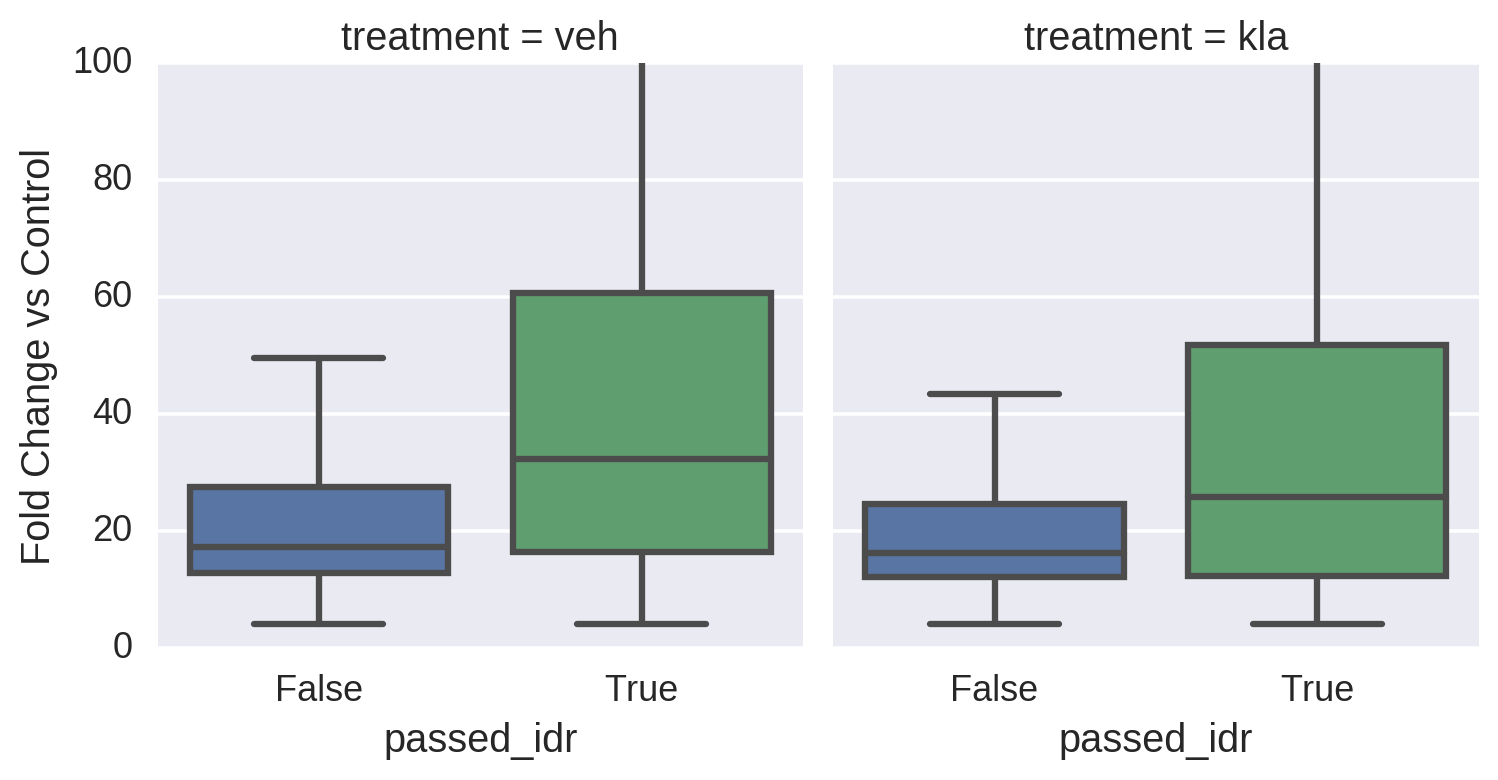

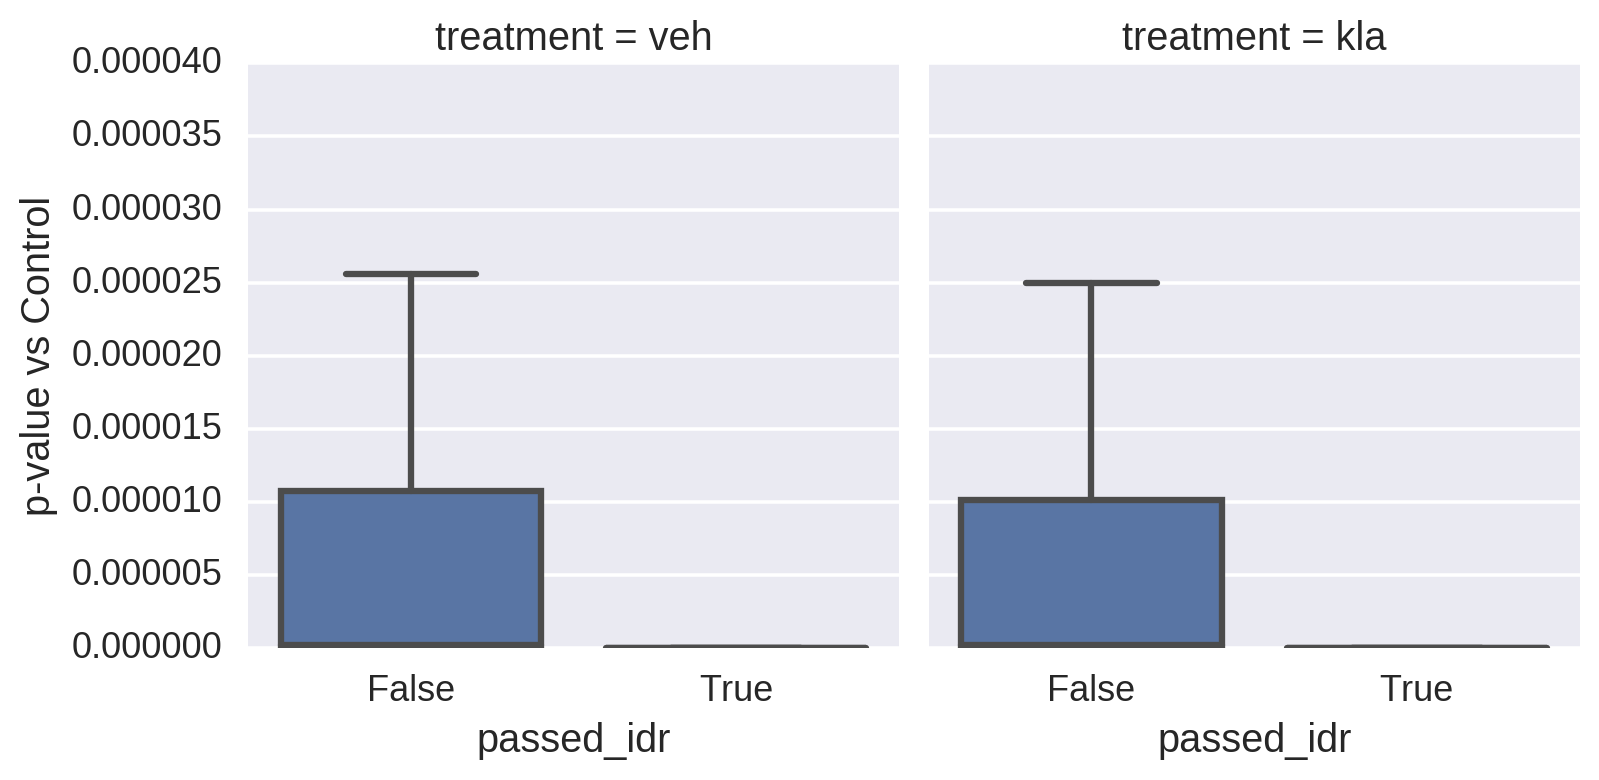

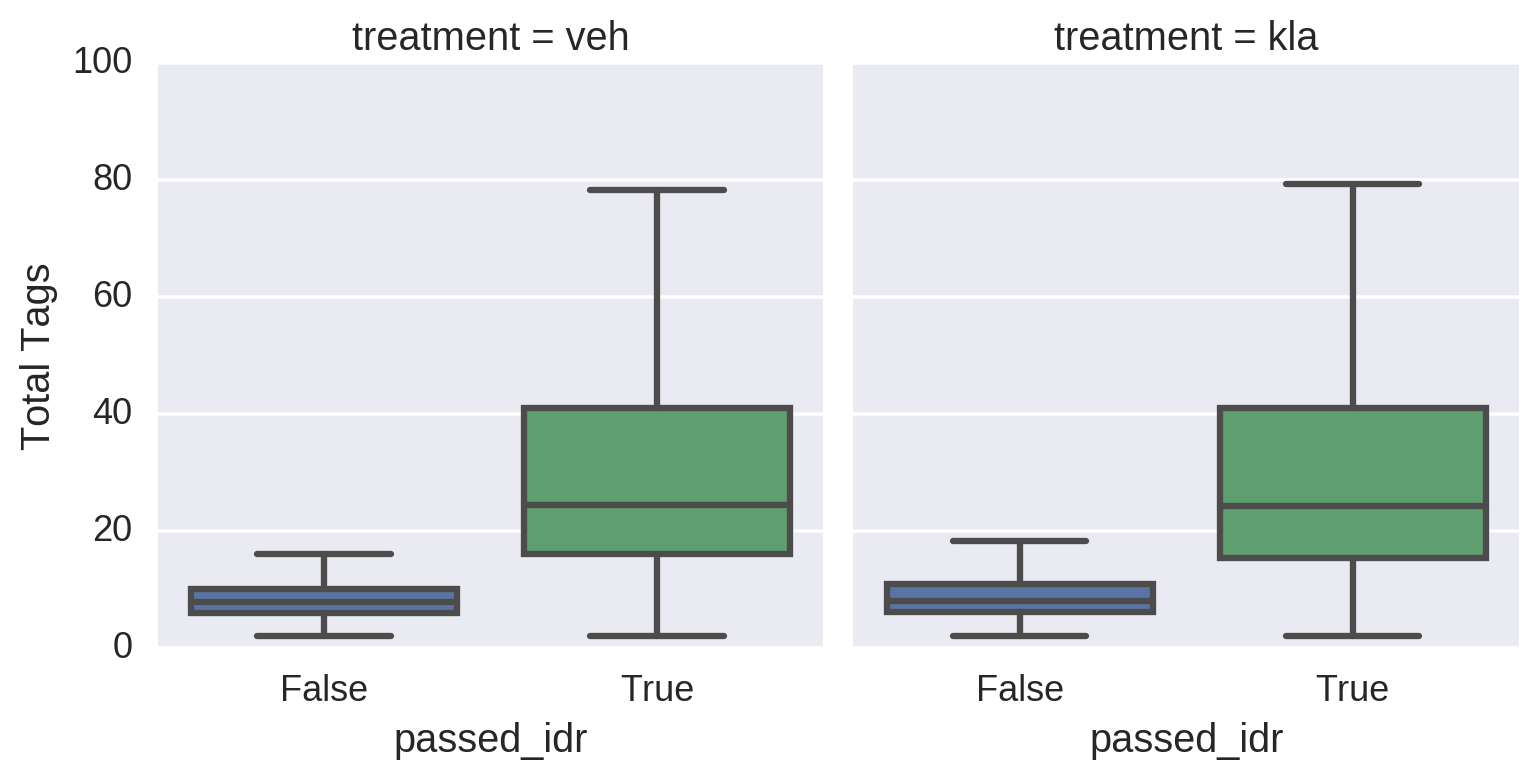

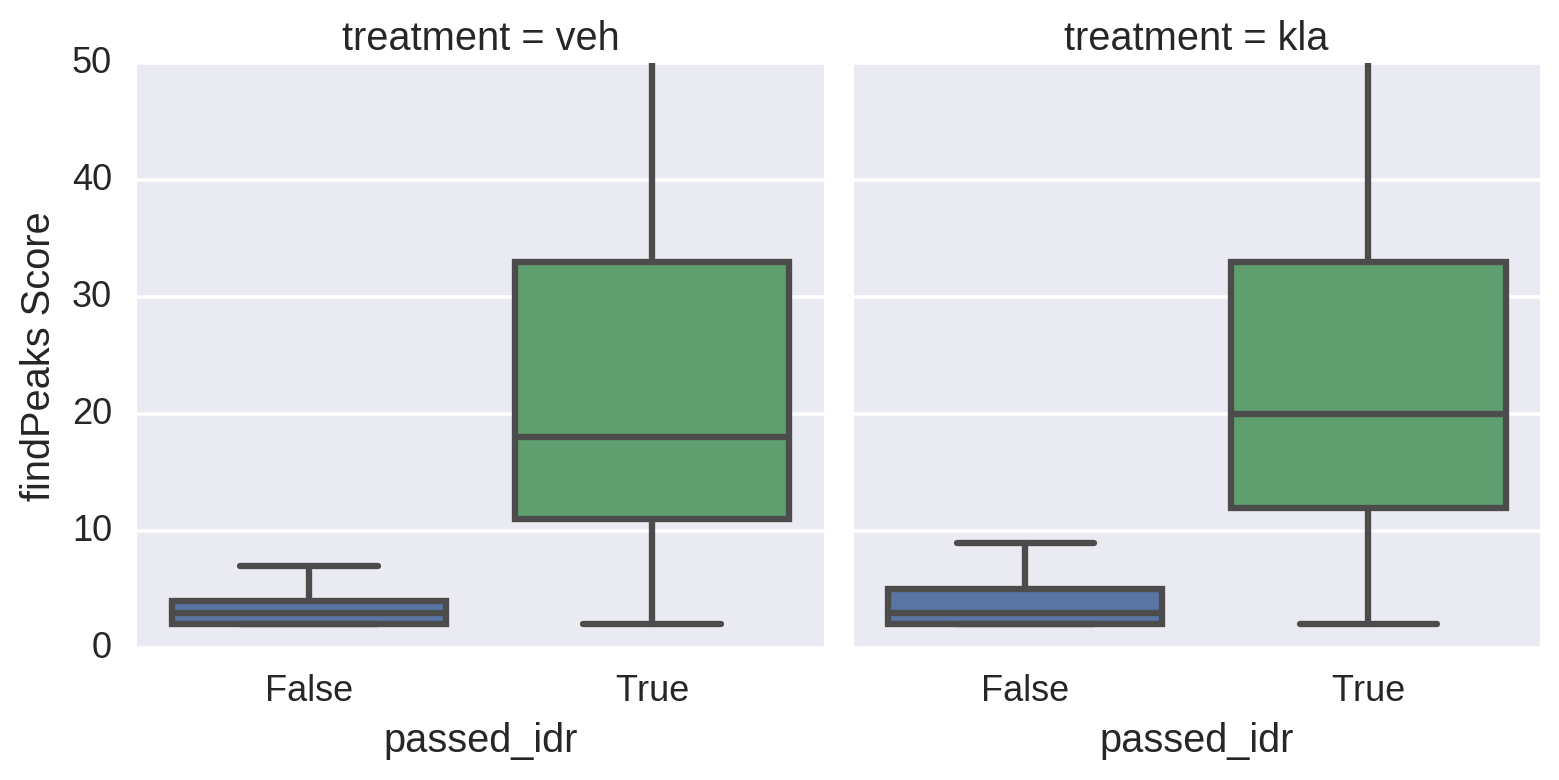

In [163]:
### summarize IDR vs non-IDR peaks
sns.factorplot(data=plotting_frame,
              y='Fold Change vs Control', 
               x='passed_idr', 
               col='treatment',
               kind='box', 
               fliersize=0, 
               order=[False, True])
plt.ylim([0,100])
plt.show()

sns.factorplot(data=plotting_frame,
              y='p-value vs Control', 
               x='passed_idr', 
               col='treatment',
               kind='box', 
               fliersize=0, 
               order=[False, True])
plt.ylim([0,0.00004])
plt.show()

sns.factorplot(data=plotting_frame,
              y='Total Tags', 
               x='passed_idr', 
               col='treatment',
               kind='box', 
               fliersize=0, 
               order=[False, True])
plt.ylim([0,100])
plt.show()

sns.factorplot(data=plotting_frame,
              y='findPeaks Score', 
               x='passed_idr', 
               col='treatment',
               kind='box', 
               fliersize=0, 
               order=[False, True])
plt.ylim([0,50])
plt.show()

In [164]:
idrDirectory = '/home/jenhan/analysis/idr_analysis/idr/'

def boxplot(data): 
    iqr = np.subtract(*np.percentile(list(data[0]) + list(data[1]), [90, 0]))
    bp = plt.boxplot(data, patch_artist= True);
    colors = ['red', 'blue'] * len(data)
    for i in range(len(bp['boxes'])):
        box = bp['boxes'][i]
        # change fill color
        box.set( facecolor = colors[i], alpha=0.5)
    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='black', alpha=0.3)
    plt.ylim([0,10*iqr])
    
    
! if [ ! -d /home/jenhan/analysis/idr_analysis/summaries/ ]; then mkdir /home/jenhan/analysis/idr_analysis/summaries/; fi
# determine how many lines to skip
numRowsToSkip = 0
for p in os.listdir(peakDirectory):
    with open (peakDirectory + '/' + p) as f:
        data = f.readlines()
    for line in data:
        if line[0] == '#':
            numRowsToSkip += 1
        else:
            break
    numRowsToSkip -= 1
    break
    
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)
for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
#             if True:
            if 'ncor' in sample1 and 'veh' in sample1:
                peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
                peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
                idrFile = idrDirectory + '/' + '_'.join([sample1, 'peaks', sample2, 'peaks', 'idr.tsv'])
                mergedFile =  './scratch/' + '_'.join([sample1, 'peaks', sample2, 'peaks', 'merged.tsv'])
                peak_frame_1= pd.read_csv(peakFile1, sep='\t', skiprows=numRowsToSkip)
                peak_frame_1.columns = [x.split(' (')[0] if 'normalized to' in x else x for x in peak_frame_1.columns.values]
                id_peakScore_dict_1 = dict(zip(peak_frame_1['#PeakID'].values, peak_frame_1['findPeaks Score'].values))
                id_tagCount_dict_1 = dict(zip(peak_frame_1['#PeakID'].values, peak_frame_1['Total Tags'].values))
                
                peak_frame_2= pd.read_csv(peakFile2, sep='\t', skiprows=numRowsToSkip)
                peak_frame_2.columns = [x.split(' (')[0] if 'normalized to' in x else x for x in peak_frame_2.columns.values]
                id_peakScore_dict_2 = dict(zip(peak_frame_2['#PeakID'].values, peak_frame_2['findPeaks Score'].values))
                id_tagCount_dict_2 = dict(zip(peak_frame_2['#PeakID'].values, peak_frame_2['Total Tags'].values))

                merged_frame = pd.read_csv(mergedFile, sep='\t',dtype='object')
                merged_frame = merged_frame.fillna('null')

                scores_1 = np.array([id_peakScore_dict_1[x] if not x == 'null' and not ',' in x 
                            else max([id_peakScore_dict_1[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[:,-3].values])
                scores_2 = np.array([id_peakScore_dict_2[x] if not x == 'null' and not ',' in x 
                            else max([id_peakScore_dict_2[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[:,-2].values])
                
                tags_1 = np.array([id_tagCount_dict_1[x] if not x == 'null' and not ',' in x 
                            else max([id_tagCount_dict_1[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[:,-3].values])
                tags_2 = np.array([id_tagCount_dict_2[x] if not x == 'null' and not ',' in x 
                            else max([id_tagCount_dict_2[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[:,-2].values])
                
                passed_idr = [True if not x == 'null' else False for x in merged_frame.ix[:,-1].values]

                # create figures
                f, axs = plt.subplots(4,2,figsize=(10,24))
                
                plt.suptitle(sample1 + ' (' + str(peak_frame_1.shape[0]) + ') ' 
                             + sample2 + ' (' + str(peak_frame_2.shape[0]) + ') idr(' +str(np.sum(passed_idr)) +')' )
                # scatter plot with peak scores
                plt.subplot(4,2,3)
                plt.scatter(scores_1/max(scores_1), scores_2/max(scores_2), color=['green' if x else 'red' for x in passed_idr], alpha=0.4)
                plt.xlabel(sample1)
                plt.ylabel(sample2)
                plt.xlim([0,1])
                plt.ylim([0,1])
                plt.title('Normalized Peak Scores')
                
                # scatter plot with tag counts
                plt.subplot(4,2,4)
                plt.scatter(tags_1, tags_2, color=['green' if x else 'red' for x in passed_idr], alpha=0.4)
                plt.xlabel(sample1)
                plt.ylabel(sample2)
                plt.title('Tag Counts')
                
                # hexplot for peaks that passed IDR
                plt.subplot(4,2,5)
                scores_1_idr = [x[0] for x in list(zip(scores_1, passed_idr)) if x[1]]
                scores_2_idr = [x[0] for x in list(zip(scores_2, passed_idr)) if x[1]]
                plt.hexbin(scores_1_idr/max(scores_1), 
                           scores_2_idr/max(scores_2), 
                           extent=[0, 1, 0, 1],
                           gridsize=10,
                           bins='log', 
                           cmap=plt.cm.Greens)
                plt.xlabel(sample1)
                plt.ylabel(sample2)
                plt.xlim([0,1])
                plt.ylim([0,1])
                plt.title('Peak Scores (passed IDR)')
                plt.gca().set_axis_bgcolor('white')
                
                # hexplot for peaks that failed IDR
                scores_1_failed = [x[0] for x in list(zip(scores_1, passed_idr)) if not x[1]]
                scores_2_failed = [x[0] for x in list(zip(scores_2, passed_idr)) if not x[1]]
                plt.subplot(4,2,6)
                plt.hexbin(scores_1_failed/max(scores_1), 
                           scores_2_failed/max(scores_2), 
                           extent=[0, 1, 0, 1],
                           gridsize=10,
                           bins='log', 
                           cmap=plt.cm.Greens)
                plt.xlabel(sample1)
                plt.ylabel(sample2)
                plt.xlim([0,1])
                plt.ylim([0,1])
                plt.title('Peak Scores (failed IDR)')
                plt.gca().set_axis_bgcolor('white')
                
                sample1_indices = set(merged_frame[merged_frame.ix[:,-3] != 'null'].index.values)
                sample2_indices = set(merged_frame[merged_frame.ix[:,-2] != 'null'].index.values)
                idr_indices = set(merged_frame[merged_frame.ix[:,-1] != 'null'].index.values)               
                intersection_indices = set(merged_frame[(merged_frame.ix[:,-3] != 'null') &
                                                     (merged_frame.ix[:,-2] != 'null')].index.values)
                intersectionOnly_indices = intersection_indices - idr_indices
                sample1Only_indices = sample1_indices - intersection_indices
                sample2Only_indices = sample2_indices - intersection_indices
                
                # venn diagrams
                try:
                    plt.subplot(4,2,1)
                    venn3([sample1_indices, sample2_indices, idr_indices], set_labels=[sample1, sample2, 'idr'])
                except:
                    pass
                
                # box plot comparing different venn diagram subsets
                
                
                # boxplot for peak scores
                # all sample 1
                allSample1_scores = np.array([id_peakScore_dict_1[x] if not x == 'null' and not ',' in x
                            else max([id_peakScore_dict_1[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[sample1_indices,-3].values])
                # all sample 2
                allSample2_scores = np.array([id_peakScore_dict_2[x] if not x == 'null' and not ',' in x 
                            else max([id_peakScore_dict_2[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[sample2_indices,-2].values]) 
                # sample 1 only
                sample1Only_scores = np.array([id_peakScore_dict_1[x] if not x == 'null' and not ',' in x 
                            else max([id_peakScore_dict_1[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[sample1Only_indices,-3].values])
                # sample 2 only
                sample2Only_scores = np.array([id_peakScore_dict_2[x] if not x == 'null' and not ',' in x 
                            else max([id_peakScore_dict_2[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[sample2Only_indices,-2].values]) 
                # intersection (scores from sample 1)
                intersection_1_scores = np.array([id_peakScore_dict_1[x] if not x == 'null' and not ',' in x 
                            else max([id_peakScore_dict_1[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[intersection_indices,-3].values]) 
                # intersection (scores from sample 2)
                intersection_2_scores = np.array([id_peakScore_dict_2[x] if not x == 'null' and not ',' in x 
                            else max([id_peakScore_dict_2[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[intersection_indices,-2].values]) 
                # idr (scores from sample 1)
                idr_1_scores = np.array([id_peakScore_dict_1[x] if not x == 'null' and not ',' in x 
                            else max([id_peakScore_dict_1[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[idr_indices,-3].values]) 
                # idr (scores from sample 2)
                idr_2_scores = np.array([id_peakScore_dict_2[x] if not x == 'null' and not ',' in x 
                            else max([id_peakScore_dict_2[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[idr_indices,-2].values]) 
                # intersection only (scores from sample 1)
                intersectionOnly_1_scores = np.array([id_peakScore_dict_1[x] if not x == 'null' and not ',' in x 
                            else max([id_peakScore_dict_1[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[intersectionOnly_indices,-3].values]) 
                # intersection only (scores from sample 2)
                intersectionOnly_2_scores = np.array([id_peakScore_dict_2[x] if not x == 'null' and not ',' in x 
                            else max([id_peakScore_dict_2[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[intersectionOnly_indices,-2].values])
                allSample1_scores = allSample1_scores[allSample1_scores > 0]
                allSample2_scores = allSample2_scores[allSample2_scores > 0]
                sample1Only_scores = sample1Only_scores[sample1Only_scores > 0]
                sample2Only_scores = sample2Only_scores[sample2Only_scores > 0]
                intersection_1_scores = intersection_1_scores[intersection_1_scores > 0]
                intersection_2_scores = intersection_2_scores[intersection_2_scores > 0]
                idr_1_scores = idr_1_scores[idr_1_scores > 0]
                idr_2_scores = idr_2_scores[idr_2_scores > 0]
                intersectionOnly_1_scores = intersectionOnly_1_scores[intersectionOnly_1_scores > 0]
                intersectionOnly_2_scores = intersectionOnly_2_scores[intersectionOnly_2_scores > 0]
                
                plt.subplot(4,2,7)
                boxplot([allSample1_scores,
                             allSample2_scores,
                             sample1Only_scores,
                             sample2Only_scores,
                             intersection_1_scores,
                             intersection_2_scores,
                             idr_1_scores,
                             idr_2_scores,
                             intersectionOnly_1_scores,
                             intersectionOnly_2_scores
                            ])
                plt.xticks(range(1,11), ['All # 1', 
                                    'All # 2', 
                                    'Only # 1', 
                                    'Only # 2',
                                    'Intersecting (#1)',
                                    'Intersecting (#2)',
                                    'IDR (#1)',
                                    'IDR (#2)',
                                    'Intersecting failed IDR (#1)',
                                    'Intersecting failed IDR (#2)'
                                    ], rotation=90);
                plt.title('Peak Scores (> 0)')
                
                # boxplot for tag counts
                allSample1_tags = np.array([id_tagCount_dict_1[x] if not x == 'null' and not ',' in x
                            else max([id_tagCount_dict_1[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[sample1_indices,-3].values])
                # all sample 2
                allSample2_tags = np.array([id_tagCount_dict_2[x] if not x == 'null' and not ',' in x 
                            else max([id_tagCount_dict_2[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[sample2_indices,-2].values]) 
                # sample 1 only
                sample1Only_tags = np.array([id_tagCount_dict_1[x] if not x == 'null' and not ',' in x 
                            else max([id_tagCount_dict_1[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[sample1Only_indices,-3].values])
                # sample 2 only
                sample2Only_tags = np.array([id_tagCount_dict_2[x] if not x == 'null' and not ',' in x 
                            else max([id_tagCount_dict_2[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[sample2Only_indices,-2].values]) 
                # intersection (tags from sample 1)
                intersection_1_tags = np.array([id_tagCount_dict_1[x] if not x == 'null' and not ',' in x 
                            else max([id_tagCount_dict_1[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[intersection_indices,-3].values]) 
                # intersection (tags from sample 2)
                intersection_2_tags = np.array([id_tagCount_dict_2[x] if not x == 'null' and not ',' in x 
                            else max([id_tagCount_dict_2[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[intersection_indices,-2].values]) 
                # idr (tags from sample 1)
                idr_1_tags = np.array([id_tagCount_dict_1[x] if not x == 'null' and not ',' in x 
                            else max([id_tagCount_dict_1[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[idr_indices,-3].values]) 
                # idr (tags from sample 2)
                idr_2_tags = np.array([id_tagCount_dict_2[x] if not x == 'null' and not ',' in x 
                            else max([id_tagCount_dict_2[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[idr_indices,-2].values]) 
                # intersection only (tags from sample 1)
                intersectionOnly_1_tags = np.array([id_tagCount_dict_1[x] if not x == 'null' and not ',' in x 
                            else max([id_tagCount_dict_1[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[intersectionOnly_indices,-3].values]) 
                # intersection only (tags from sample 2)
                intersectionOnly_2_tags = np.array([id_tagCount_dict_2[x] if not x == 'null' and not ',' in x 
                            else max([id_tagCount_dict_2[y] for y in x.split(',')]) if ',' in x 
                            else 0 for x in merged_frame.ix[intersectionOnly_indices,-2].values])
                allSample1_tags = allSample1_tags[allSample1_tags > 0]
                allSample2_tags = allSample2_tags[allSample2_tags > 0]
                sample1Only_tags = sample1Only_tags[sample1Only_tags > 0]
                sample2Only_tags = sample2Only_tags[sample2Only_tags > 0]
                intersection_1_tags = intersection_1_tags[intersection_1_tags > 0]
                intersection_2_tags = intersection_2_tags[intersection_2_tags > 0]
                idr_1_tags = idr_1_tags[idr_1_tags > 0]
                idr_2_tags = idr_2_tags[idr_2_tags > 0]
                intersectionOnly_1_tags = intersectionOnly_1_tags[intersectionOnly_1_tags > 0]
                intersectionOnly_2_tags = intersectionOnly_2_tags[intersectionOnly_2_tags > 0]
                plt.subplot(4,2,8)
                boxplot([allSample1_tags,
                             allSample2_tags,
                             sample1Only_tags,
                             sample2Only_tags,
                             intersection_1_tags,
                             intersection_2_tags,
                             idr_1_tags,
                             idr_2_tags,
                             intersectionOnly_1_tags,
                             intersectionOnly_2_tags
                            ])
                plt.xticks(range(1,11), ['All # 1',
                                    'All # 2',
                                    'Only # 1',
                                    'Only # 2',
                                    'Intersecting (#1)',
                                    'Intersecting (#2)',
                                    'IDR (#1)',
                                    'IDR (#2)',
                                    'Intersecting failed IDR (#1)',
                                    'Intersecting failed IDR (#2)'
                                    ], rotation=90);
                plt.title('Tag Counts(> 0)')
                axs[0,1].axis('off') # turn off empty grid
                                                      
                plt.savefig('./summaries/'+sample1+'_' + sample2+'_summary.png')
                plt.close()
                
                



/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:58: UserWarning: Circle C has zero area
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [165]:
### calculate the skew of each sample
current_frame = plotting_frame
sns.set_context('notebook')
replicateIndices = []
sample_skew_dict = {}
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
            skew1 = scipy.stats.skew(plotting_frame[plotting_frame['sample']==sample1]['Normalized Tag Count'].values)
            skew2 = scipy.stats.skew(plotting_frame[plotting_frame['sample']==sample2]['Normalized Tag Count'].values)
            
            sample_skew_dict[sample1] = skew1
            sample_skew_dict[sample2] = skew2
filtered_summary_frame['Normalized Tag Count Skew'] = [sample_skew_dict[x] for x in filtered_summary_frame['simplifiedName'].values]



[ 0.]


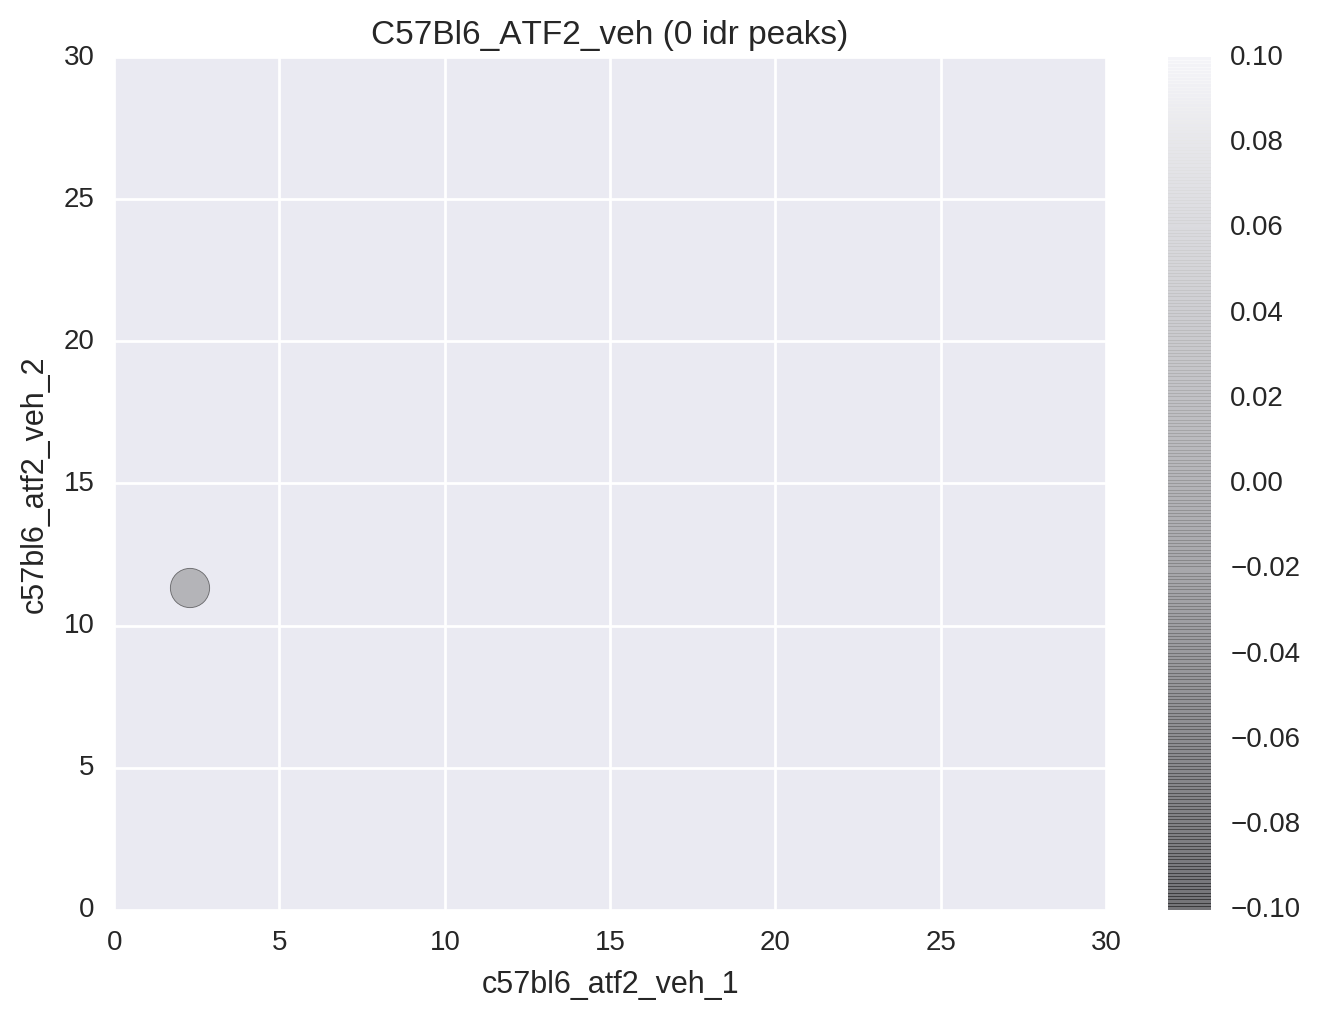

[ 0.          0.          0.97297297  0.40540541  0.          0.        ]


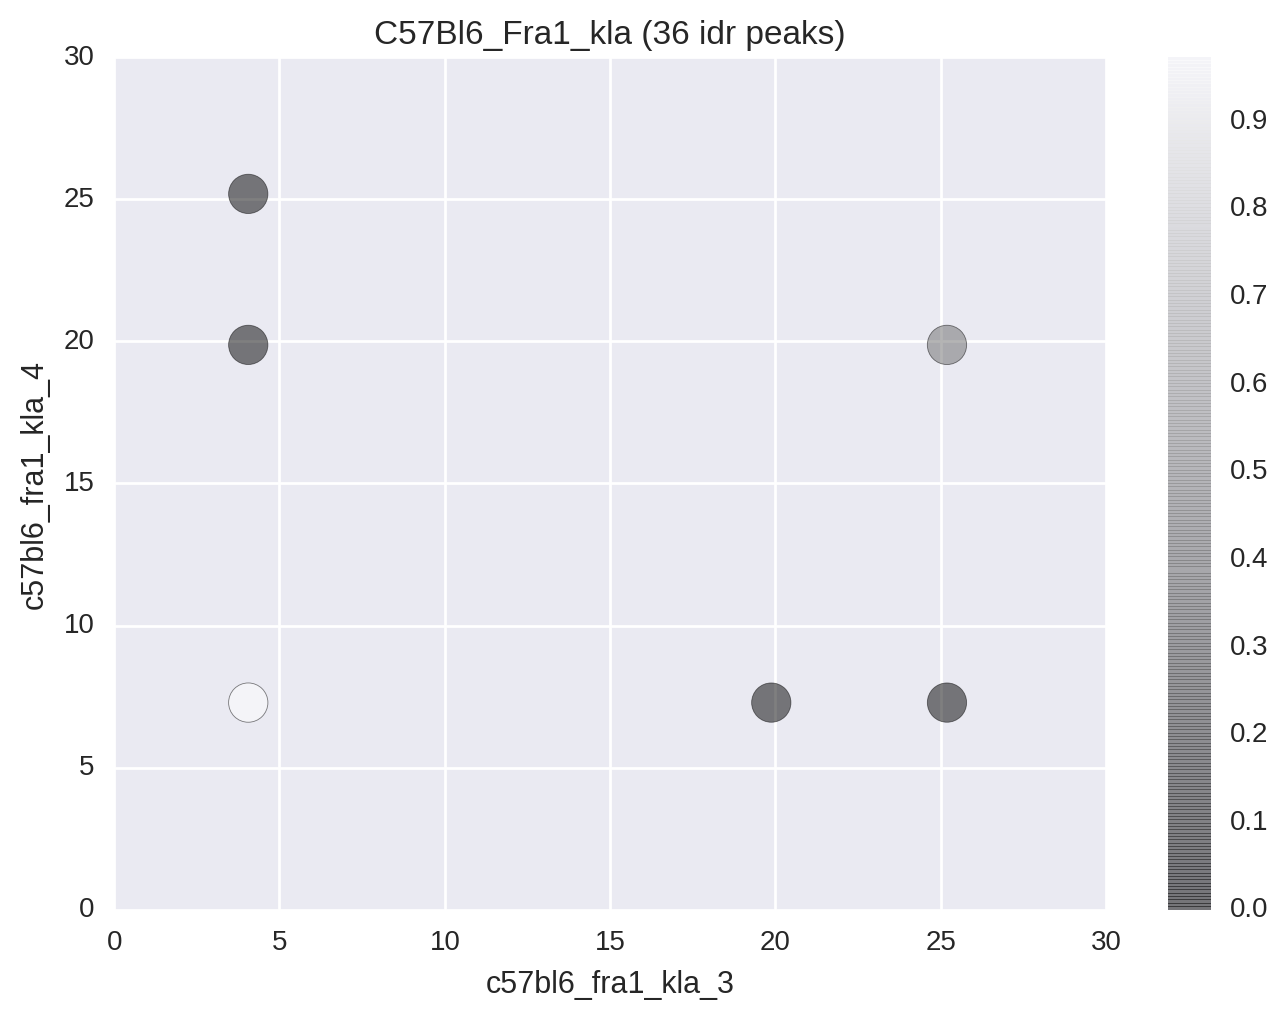

[ 0.99985722]


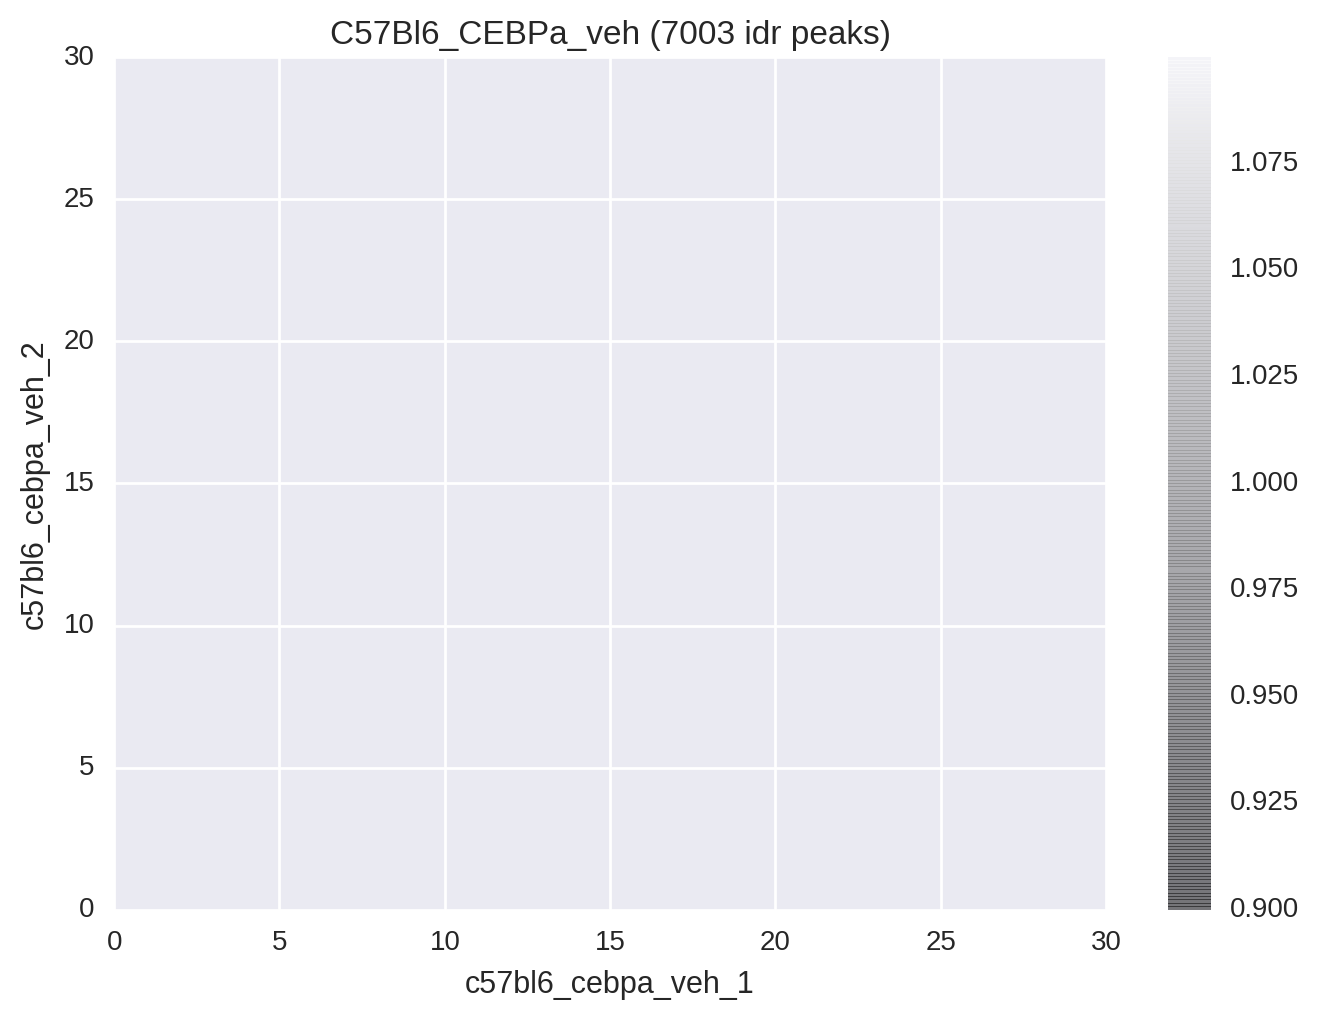

[ 0.01282051  0.          0.          0.98717949  0.          0.78205128]


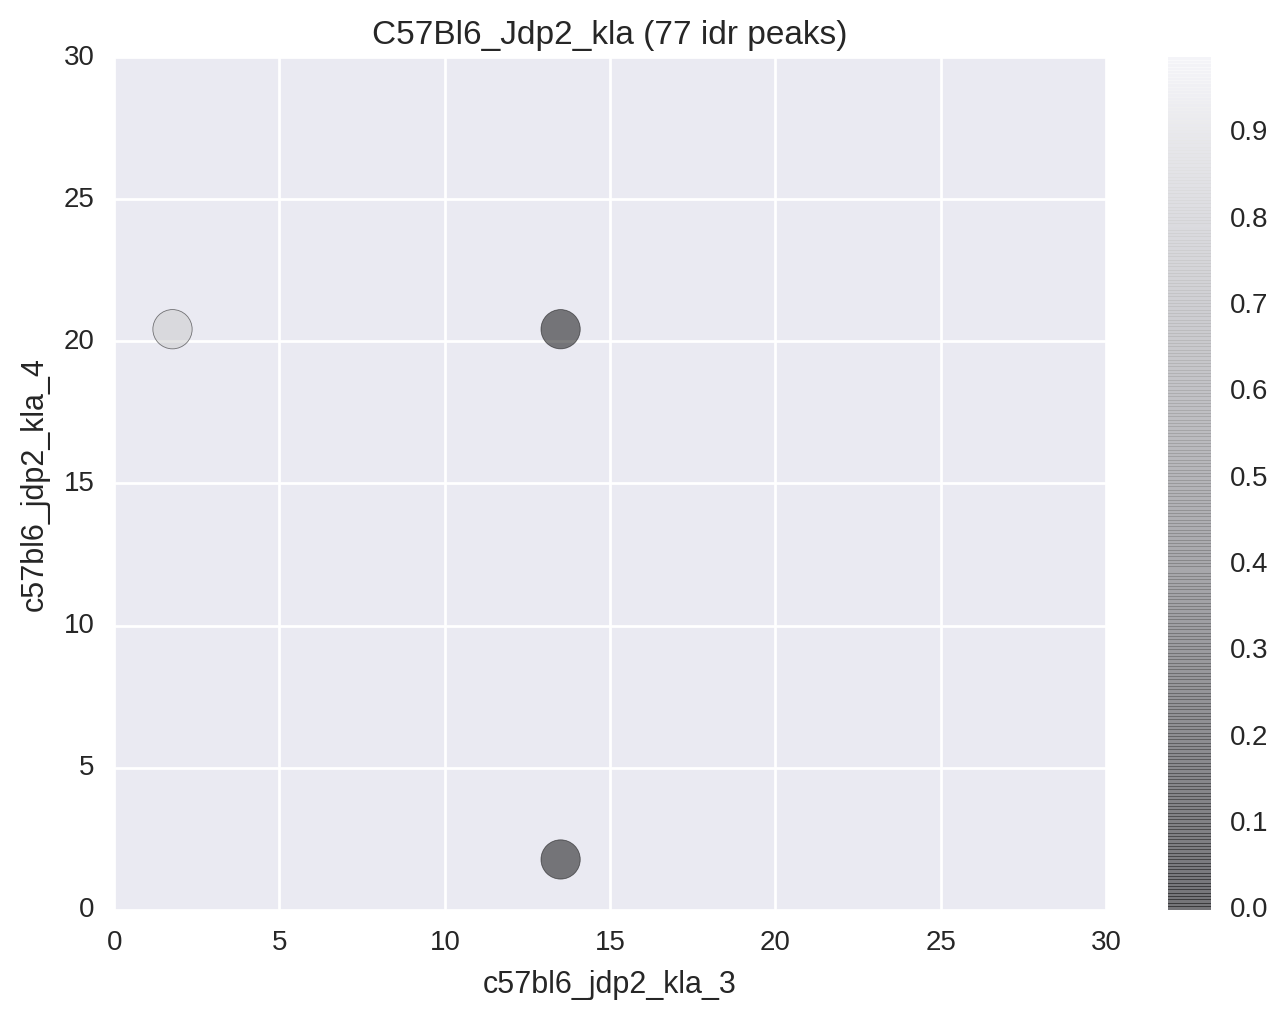

[  6.68699497e-01   6.86080195e-03   9.99847538e-01   3.12090258e-01
   2.13447172e-03   4.37109315e-01   2.57203842e-01   4.57386797e-04
   6.40341515e-03   2.36926361e-01]


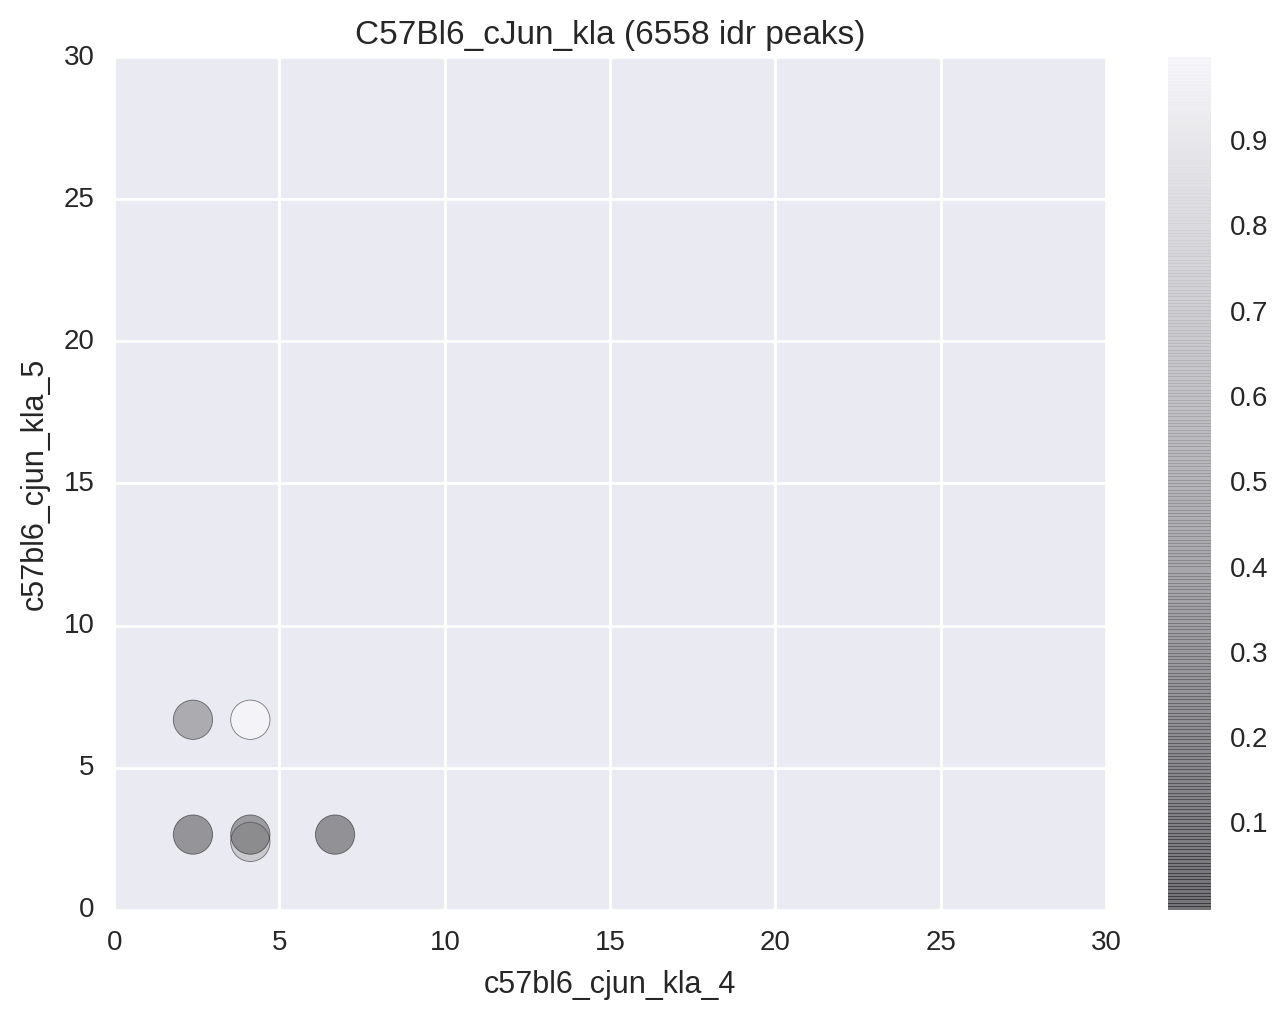

[  2.30982906e-01   1.96367521e-01   2.99145299e-04   2.02606838e-01
   5.44444444e-02   1.30769231e-01   1.98076923e-01   0.00000000e+00
   9.99957265e-01   4.25299145e-01   7.38675214e-01   2.13675214e-04
   2.12606838e-01   5.73931624e-02   1.21623932e-01   2.13675214e-04
   5.55555556e-04   4.27350427e-05   3.33589744e-01   4.68547009e-01
   2.63632479e-01]


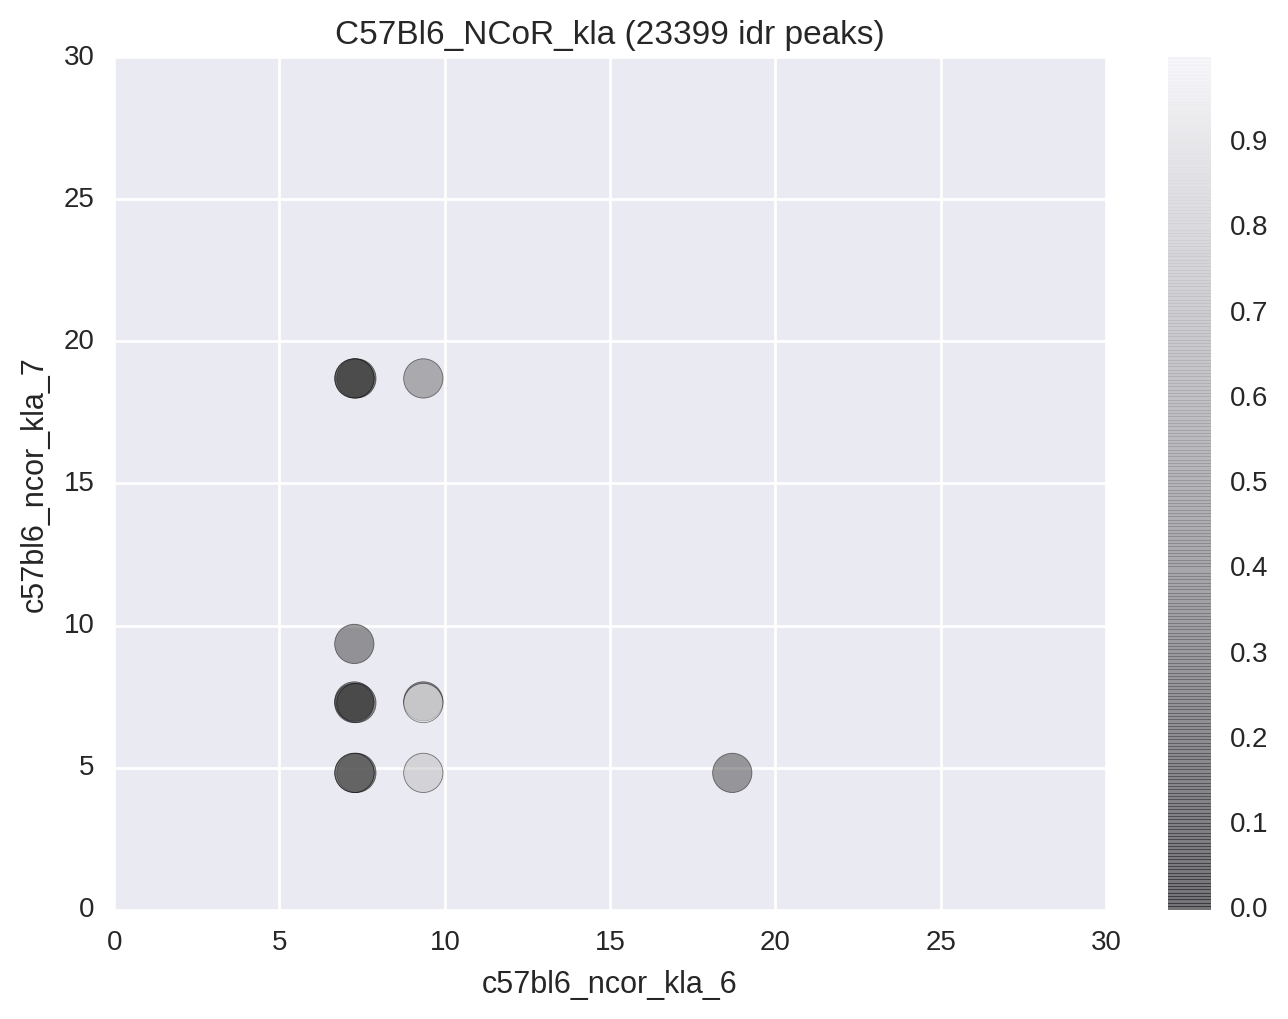

[ 0.94117647]


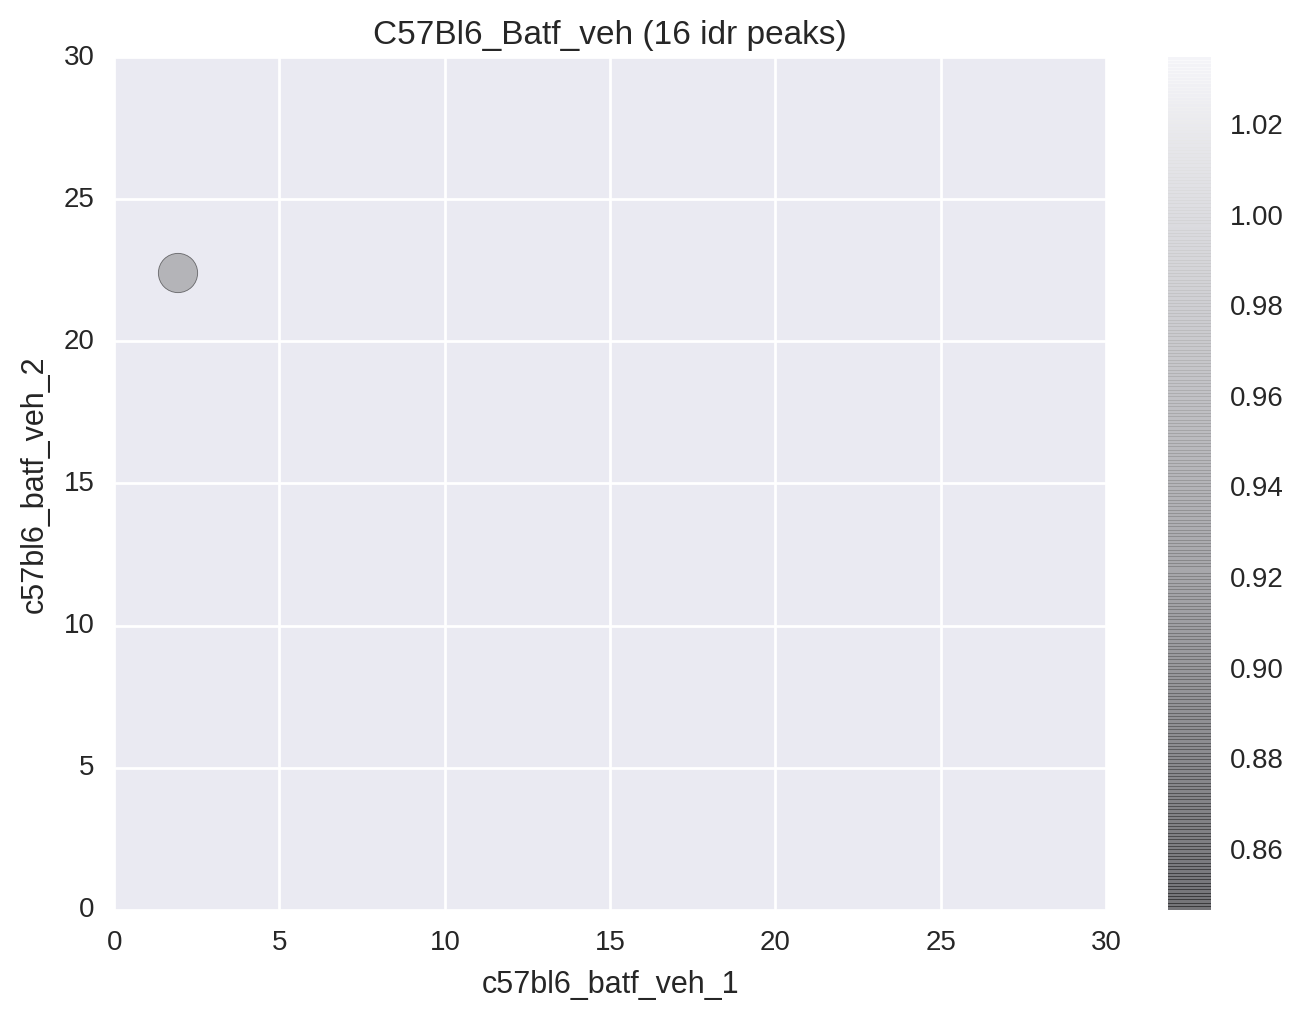

[ 0.99774266]


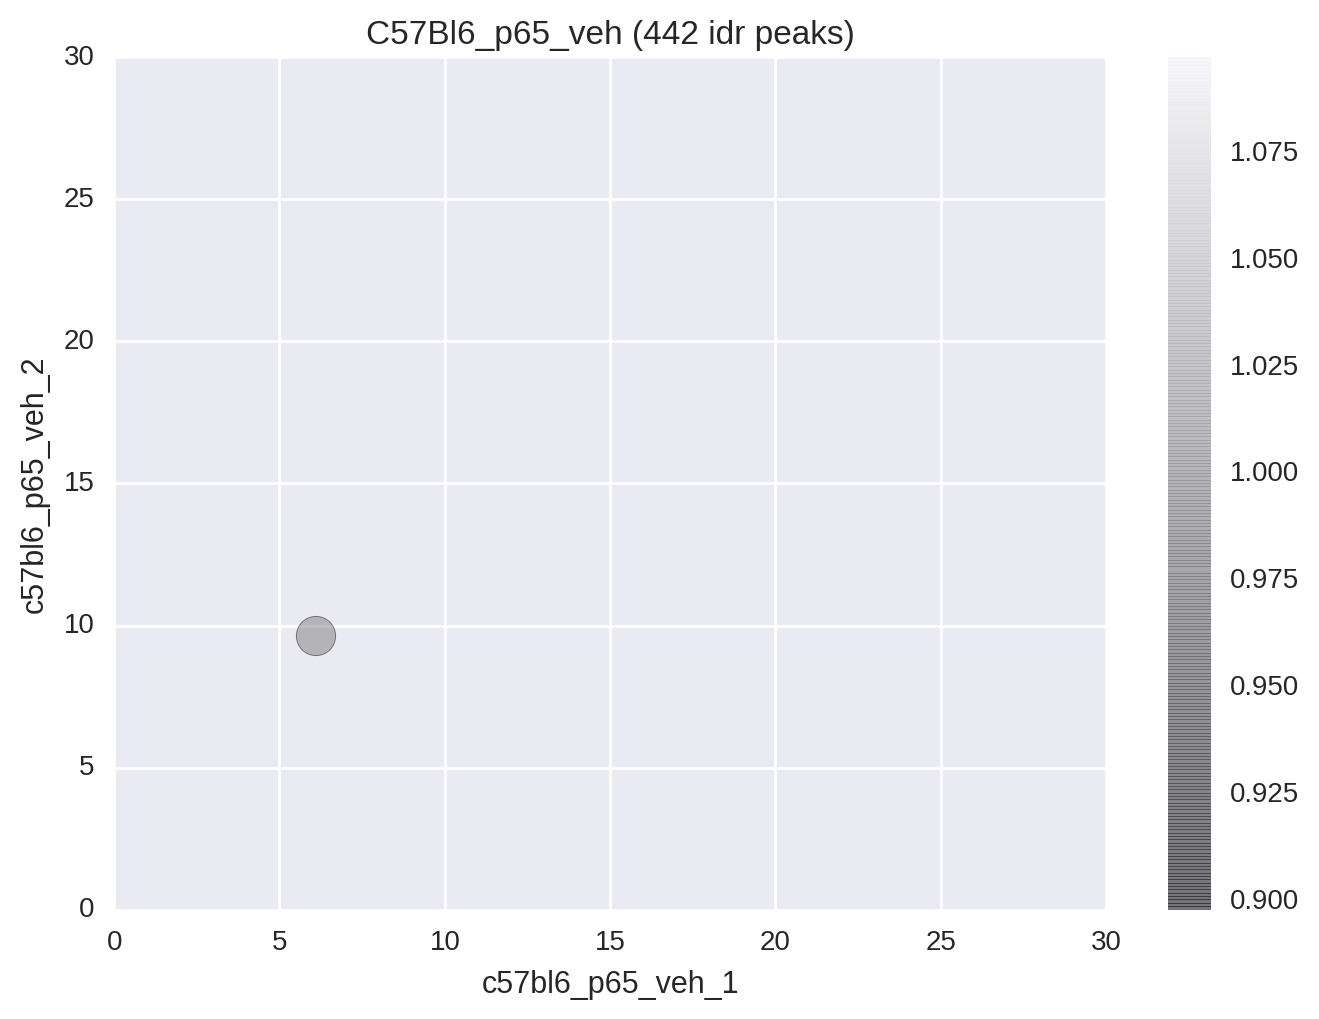

[ 0.98507463]


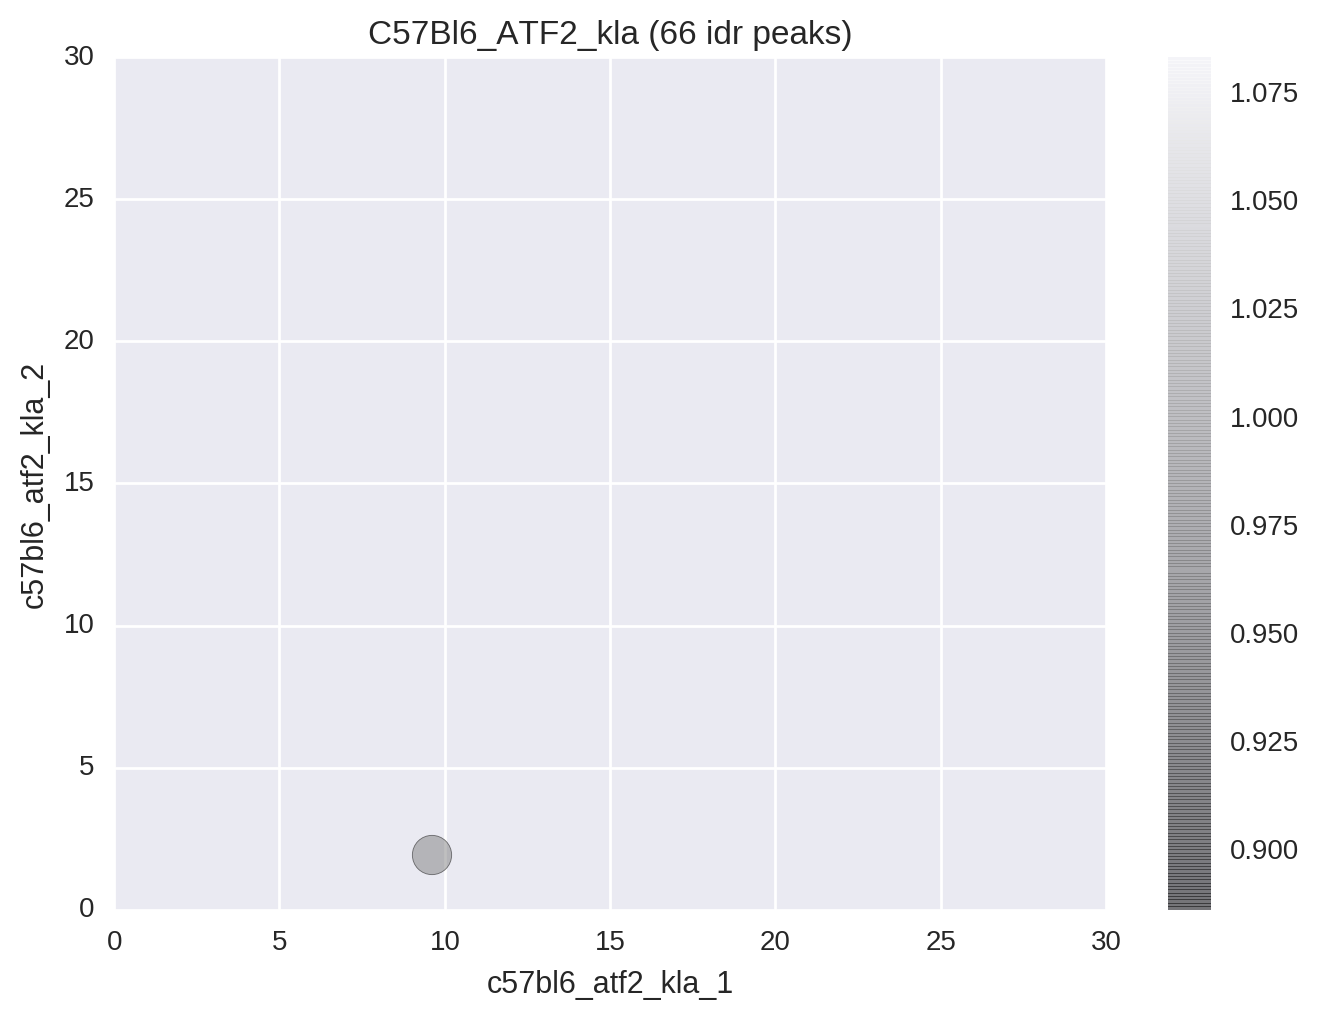

[  4.07830343e-03   1.36541599e-01   9.99836868e-01   4.89396411e-04
   0.00000000e+00   5.38336052e-03   0.00000000e+00   2.81239804e-01
   1.14192496e-03   2.70799347e-02]


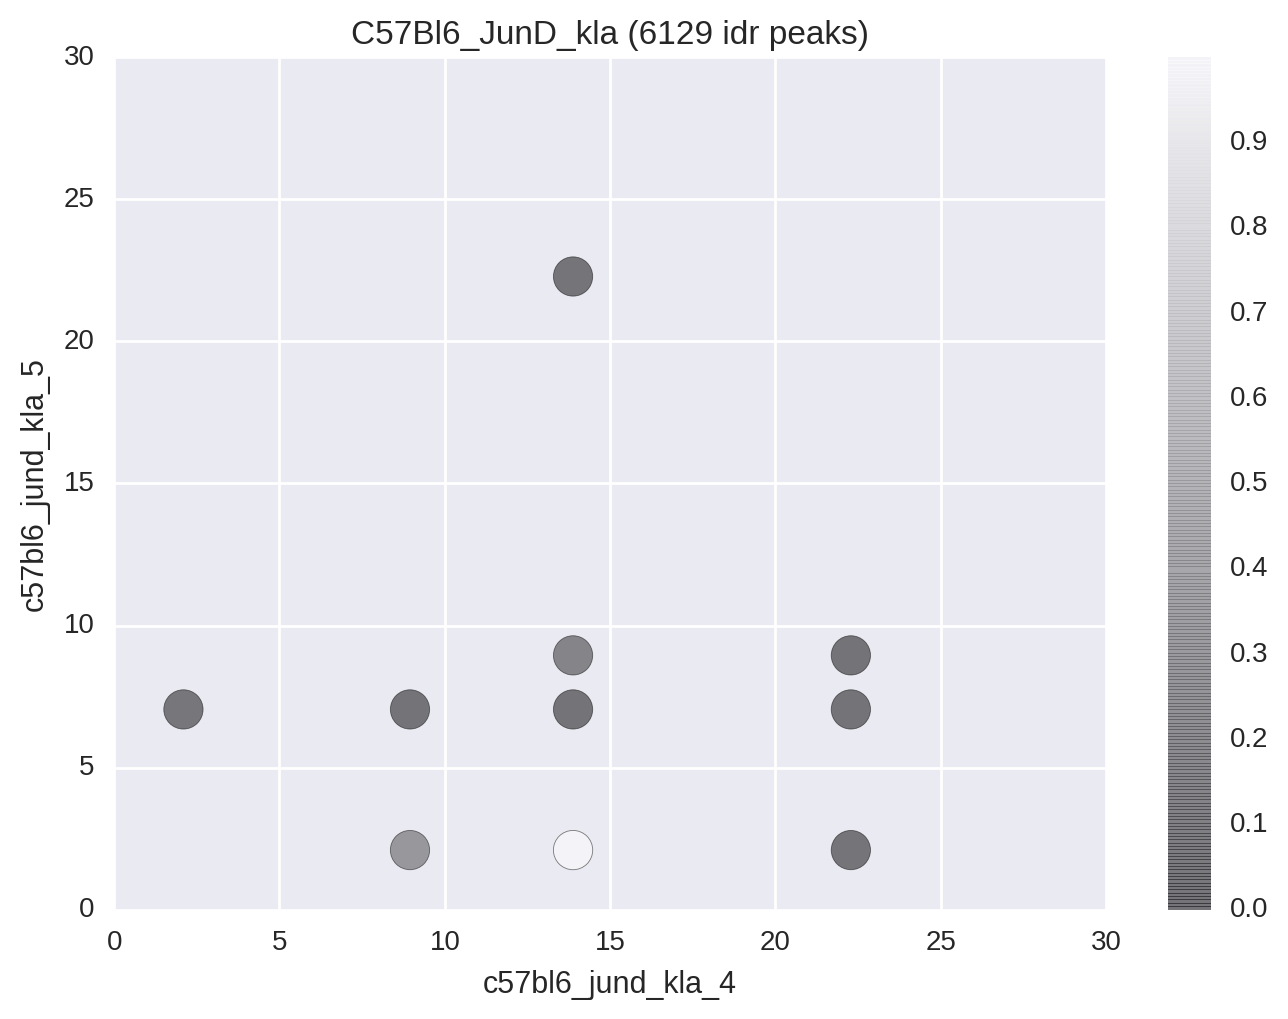

[ 0.]


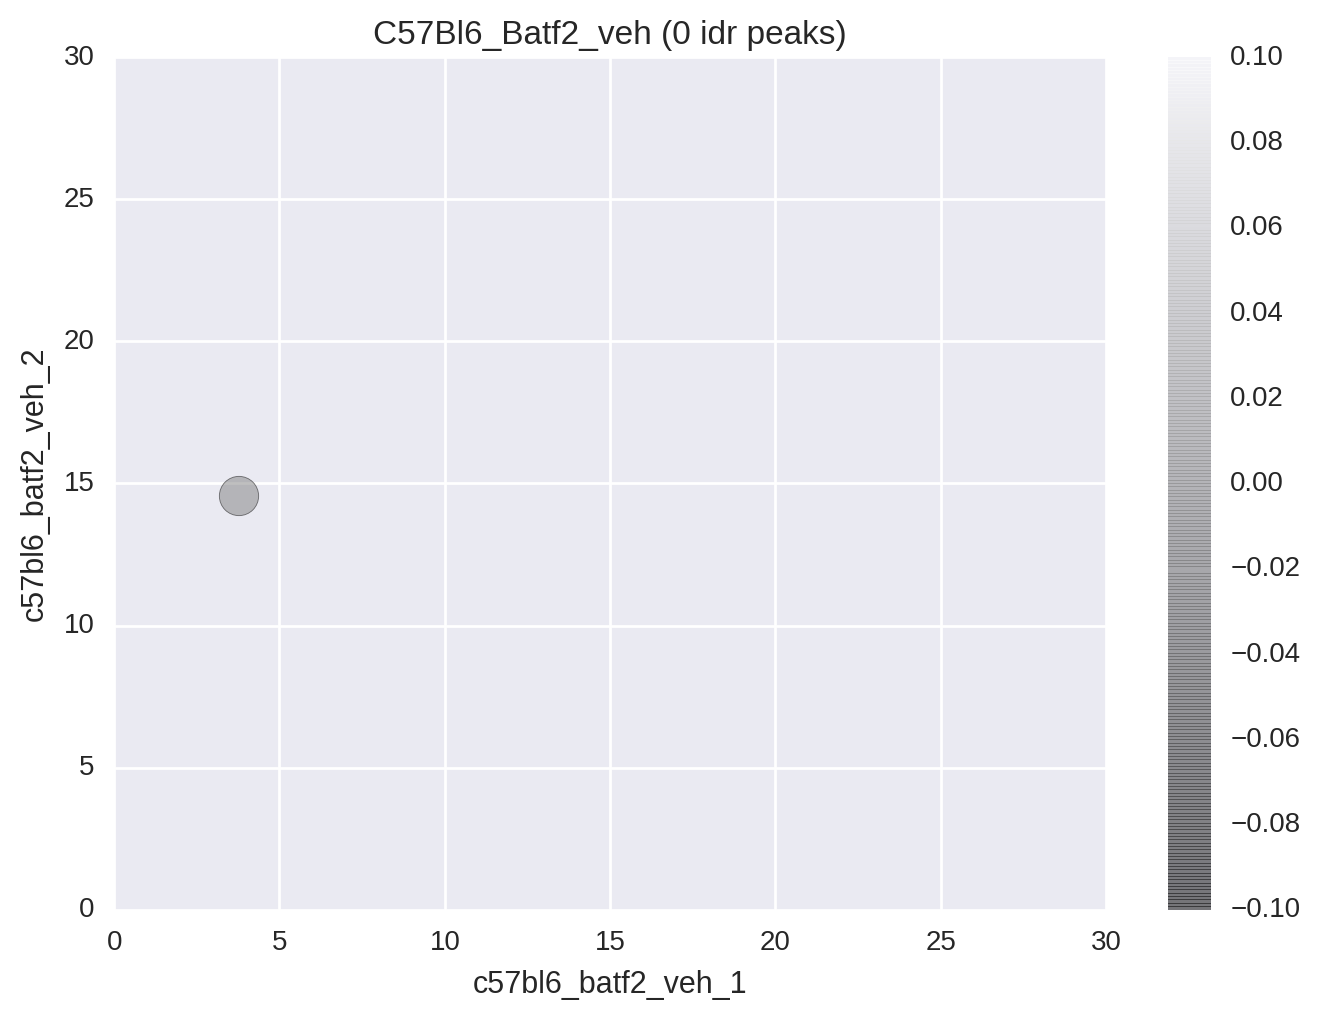

[ 0.99988621]


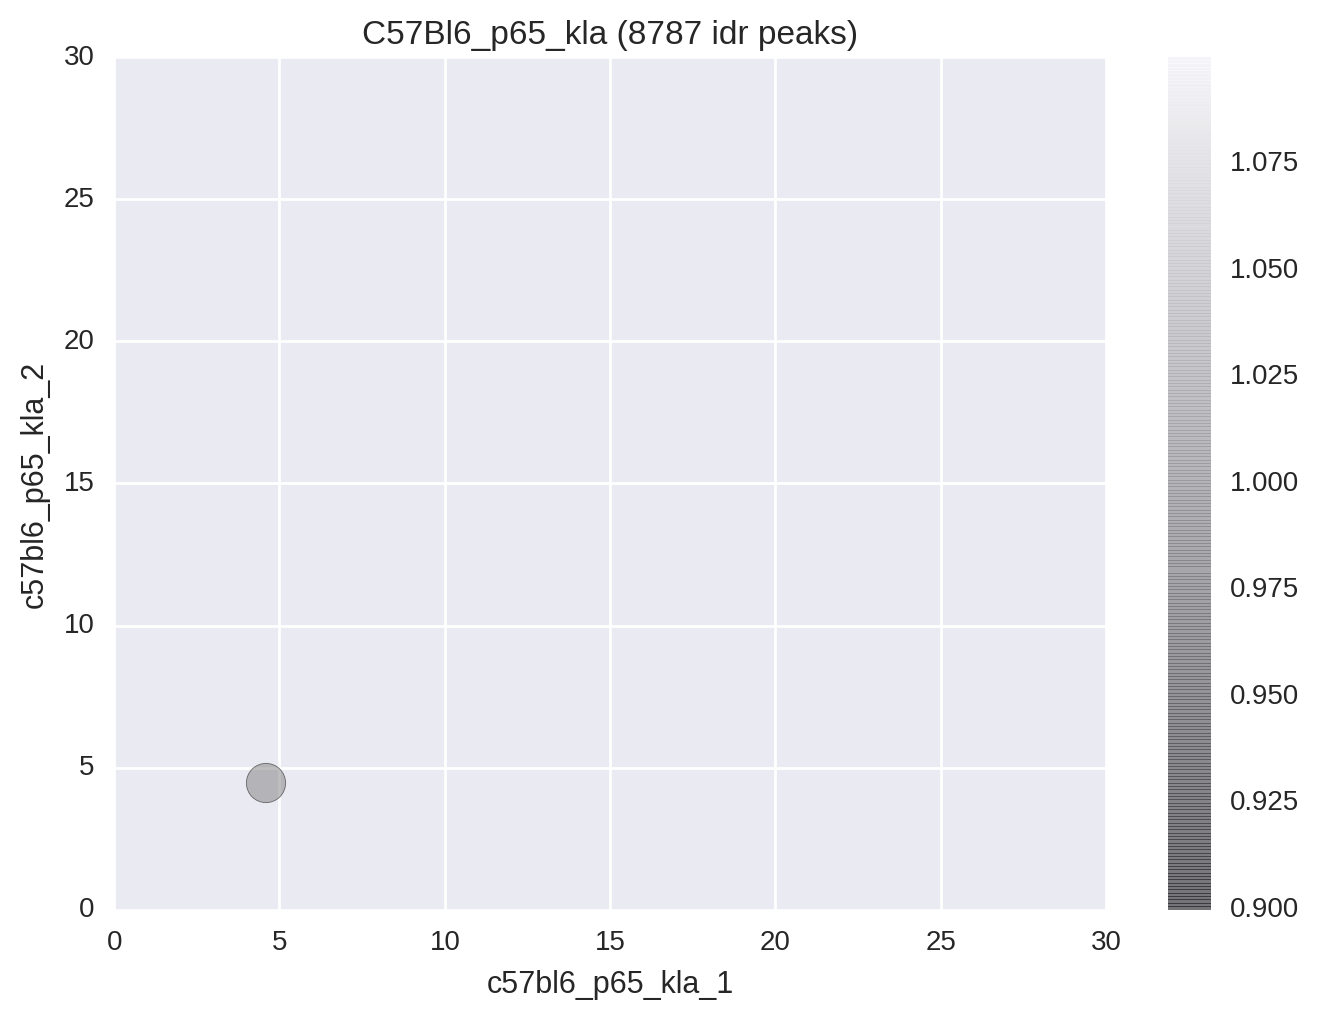

[ 0.00431034  0.          0.18103448  0.          0.98275862  0.43965517
  0.99568966  0.          0.11637931  0.05172414]


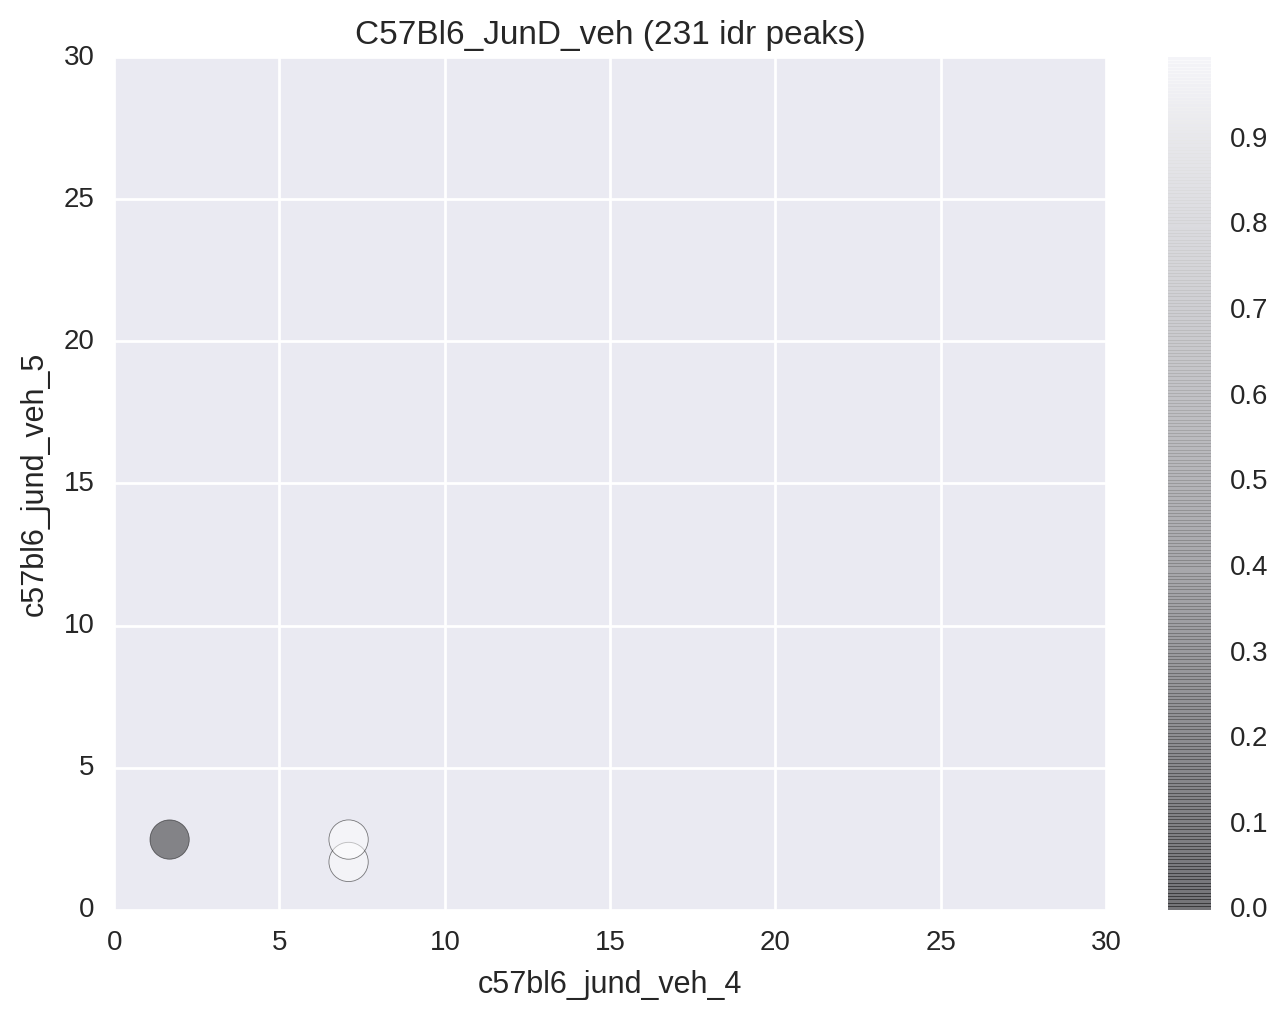

[ 0.          0.02926829  0.83902439  0.          0.          0.07560976
  0.          0.0097561   0.05609756  0.99756098]


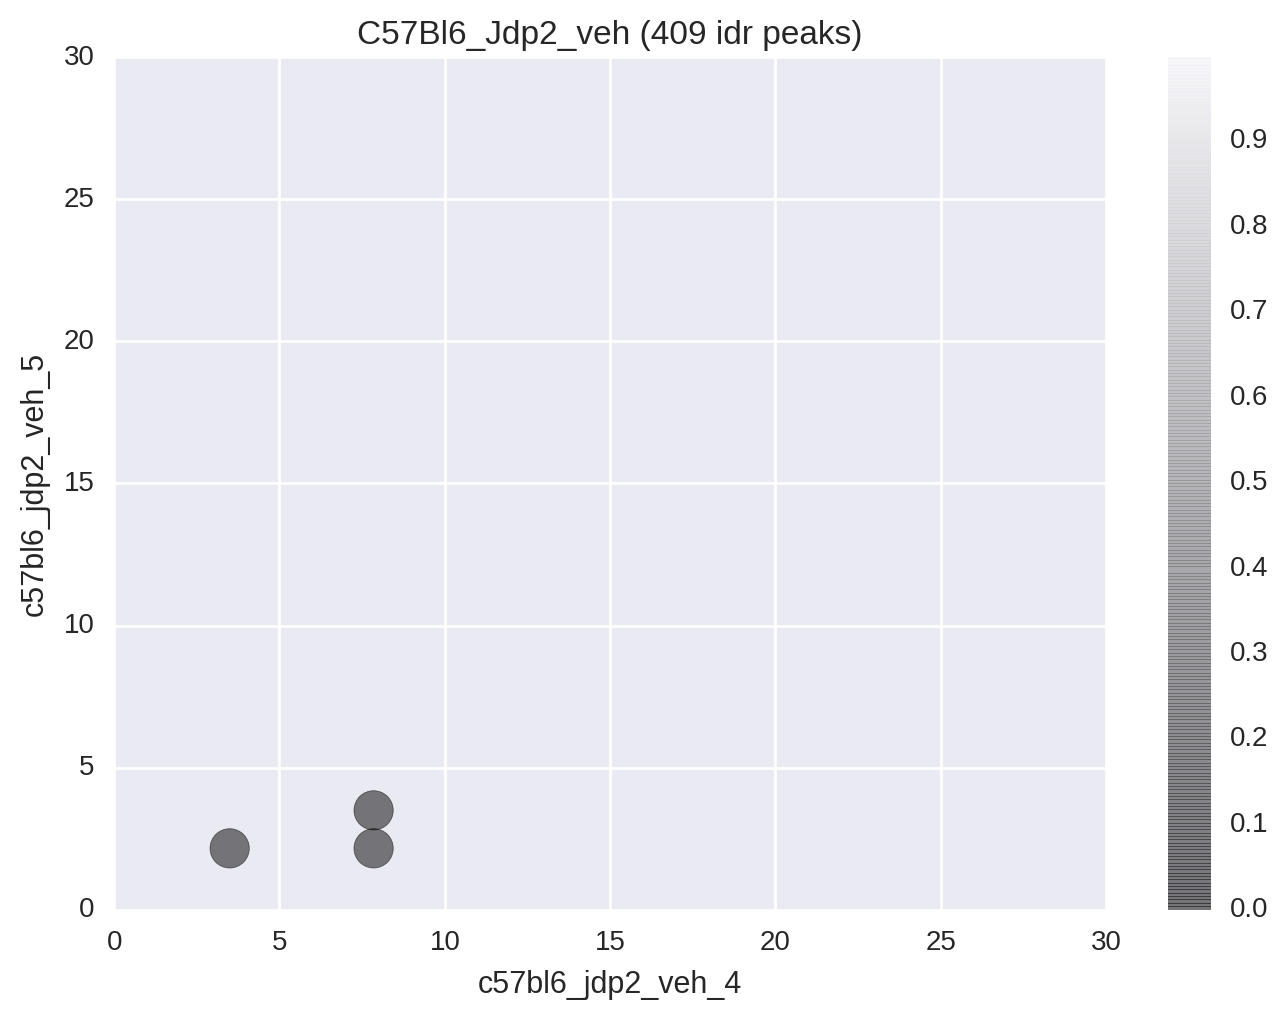

[  2.01660735e-03   9.99940688e-01   1.01423488e-01   4.56702254e-03
   9.48991696e-04   1.08185053e-01]


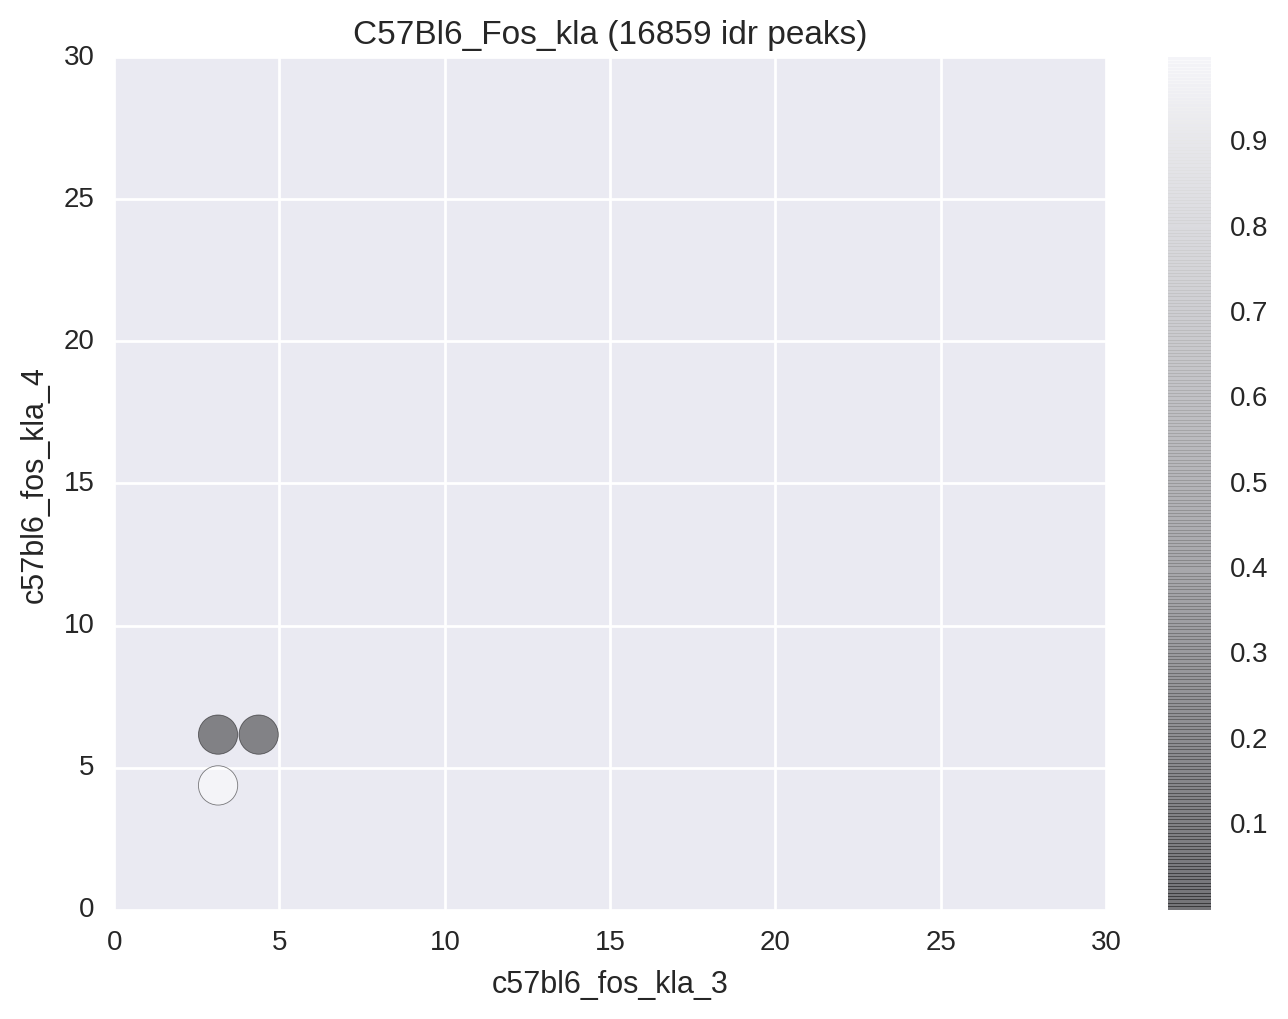

[ 0.29364005  0.99864682  0.03653586  0.30040595  0.          0.        ]


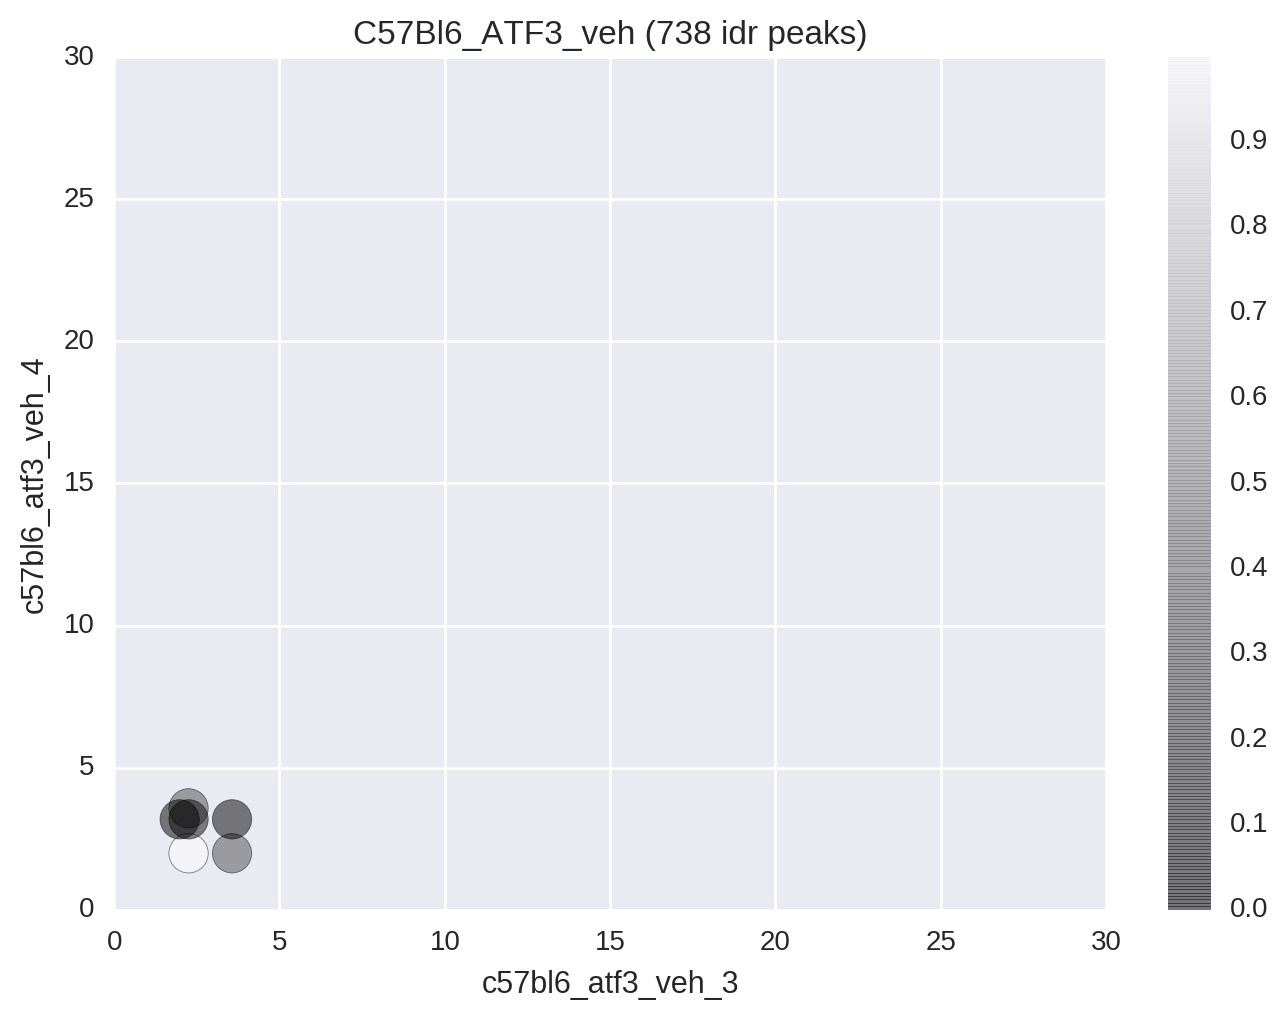

[ 0.13207547  0.99528302  0.          0.          0.          0.        ]


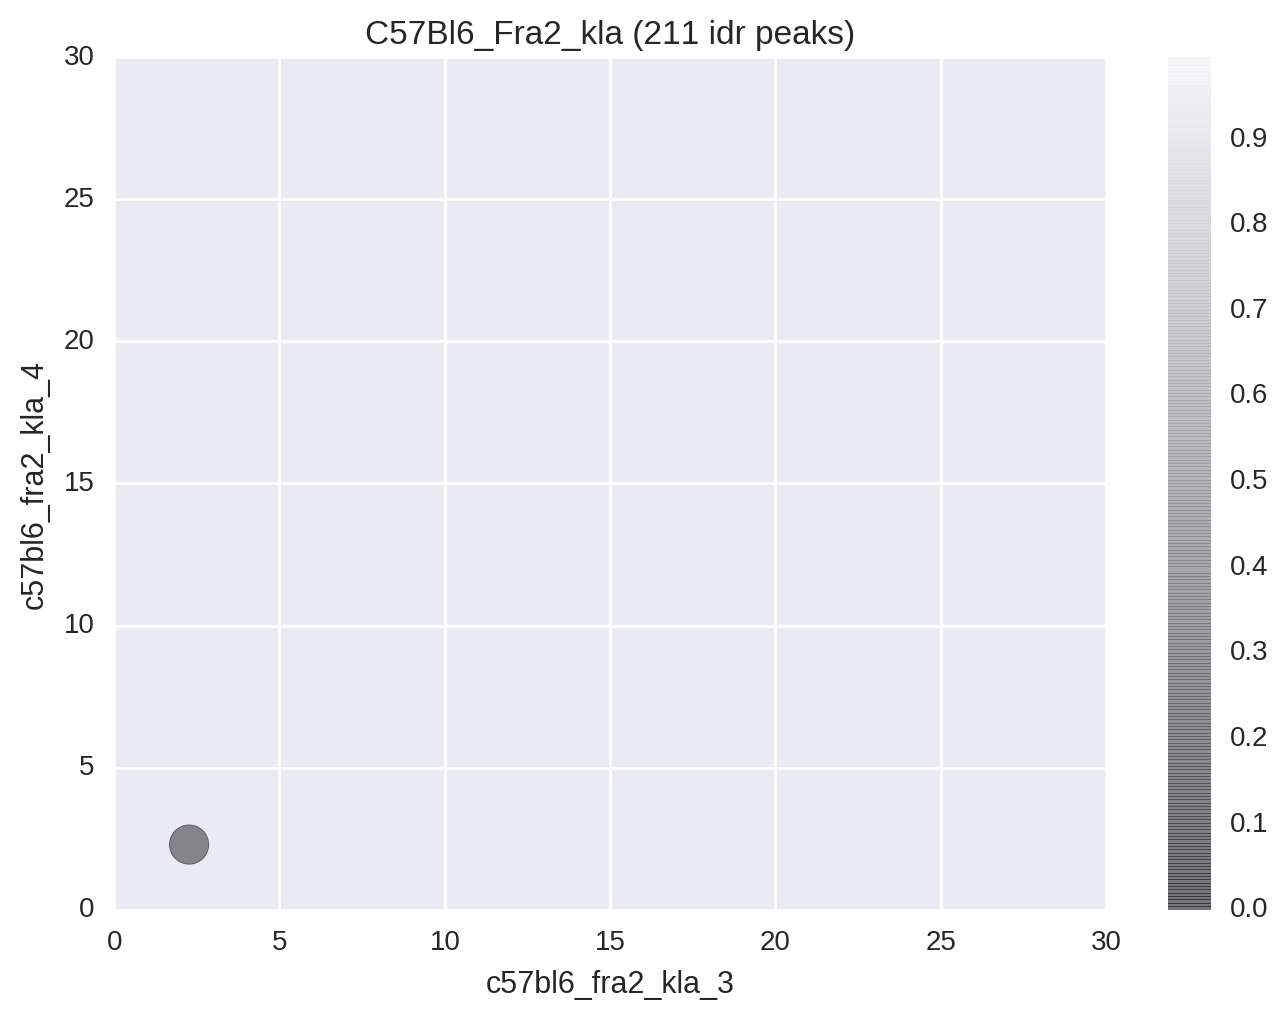

[ 0.]


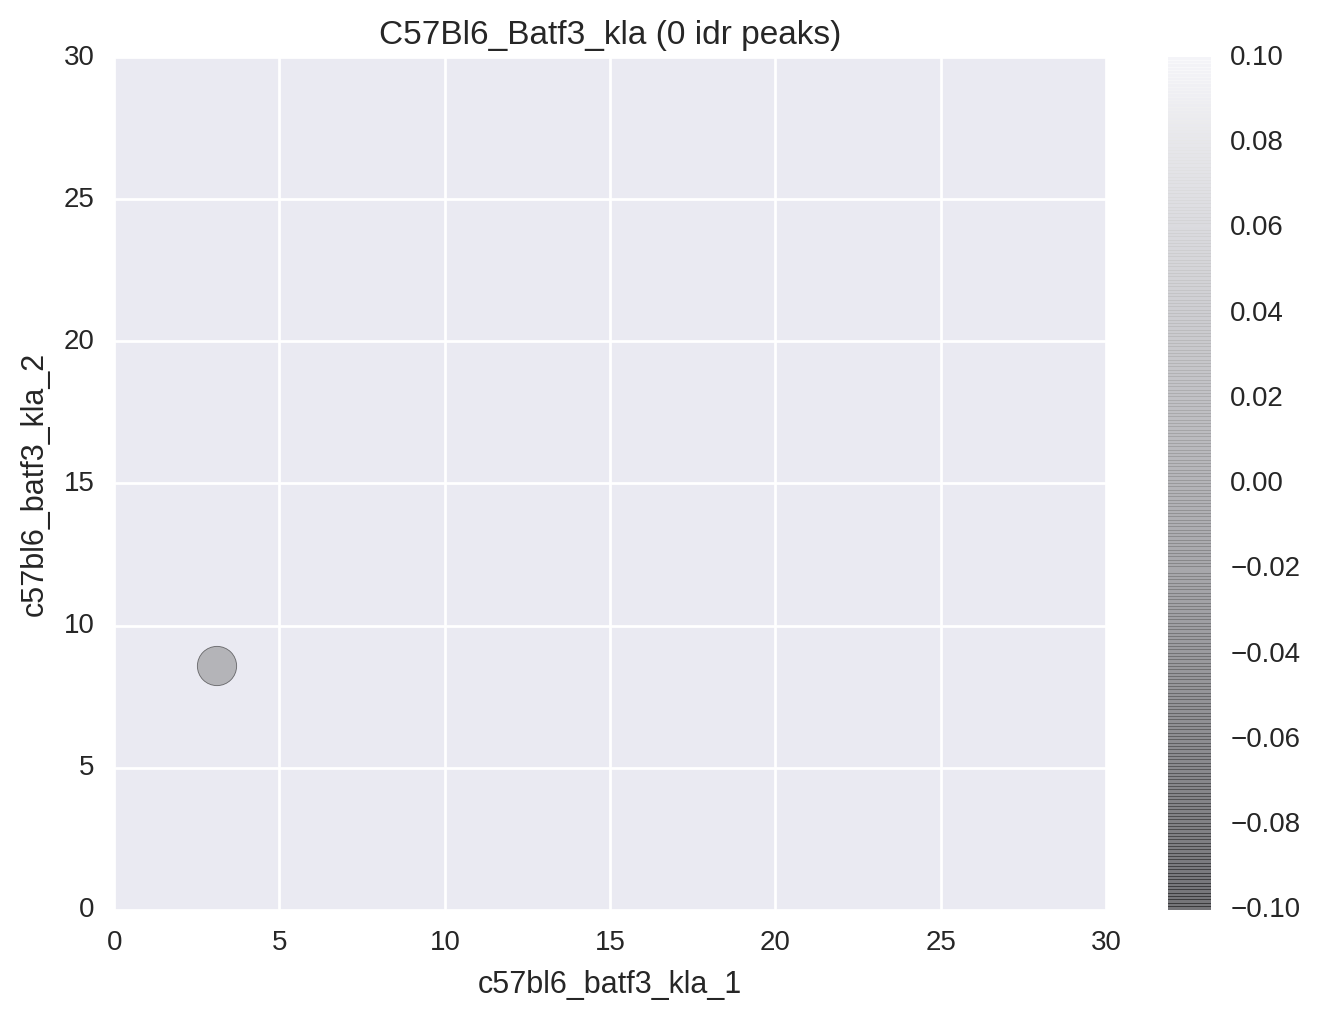

[ 0.          0.          0.09638554  0.01004016  0.99799197  0.13654618]


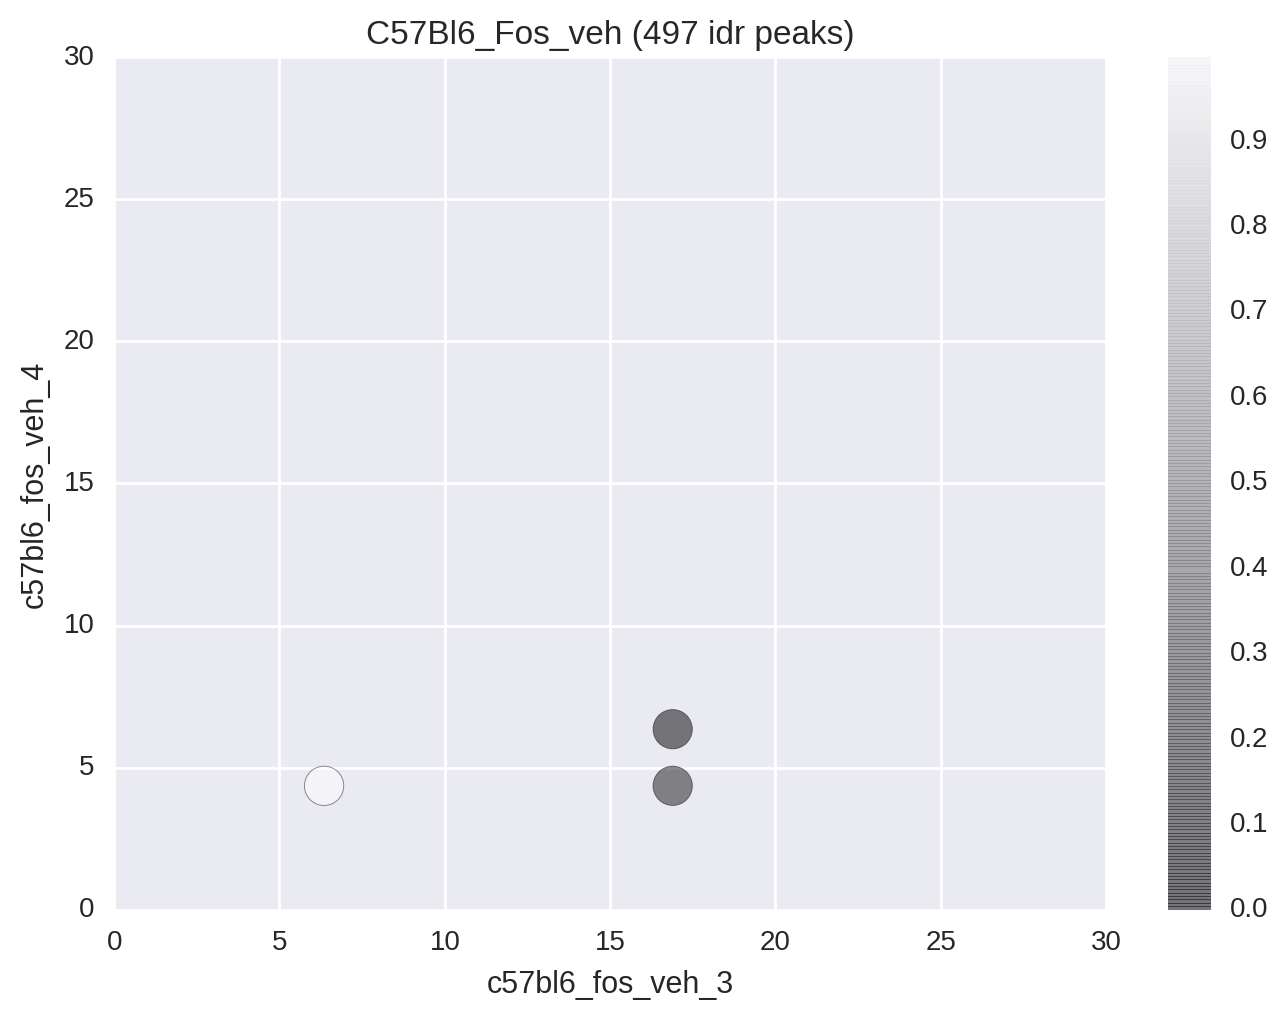

[ 0.97619048]


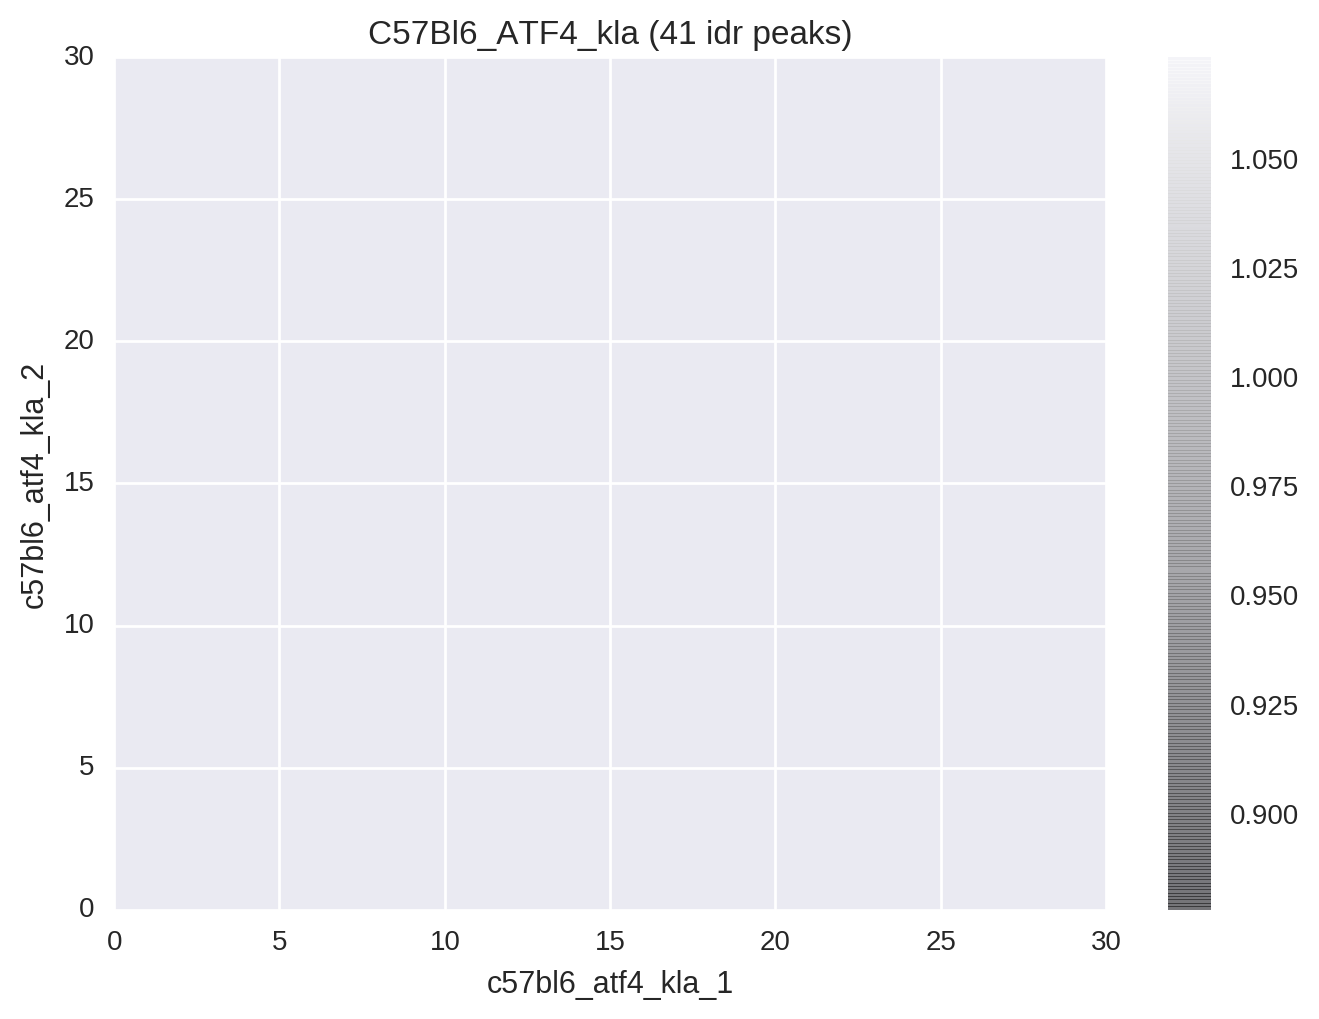

[ 0.99980064  0.00976874  0.23305423  0.          0.24541467  0.00897129]


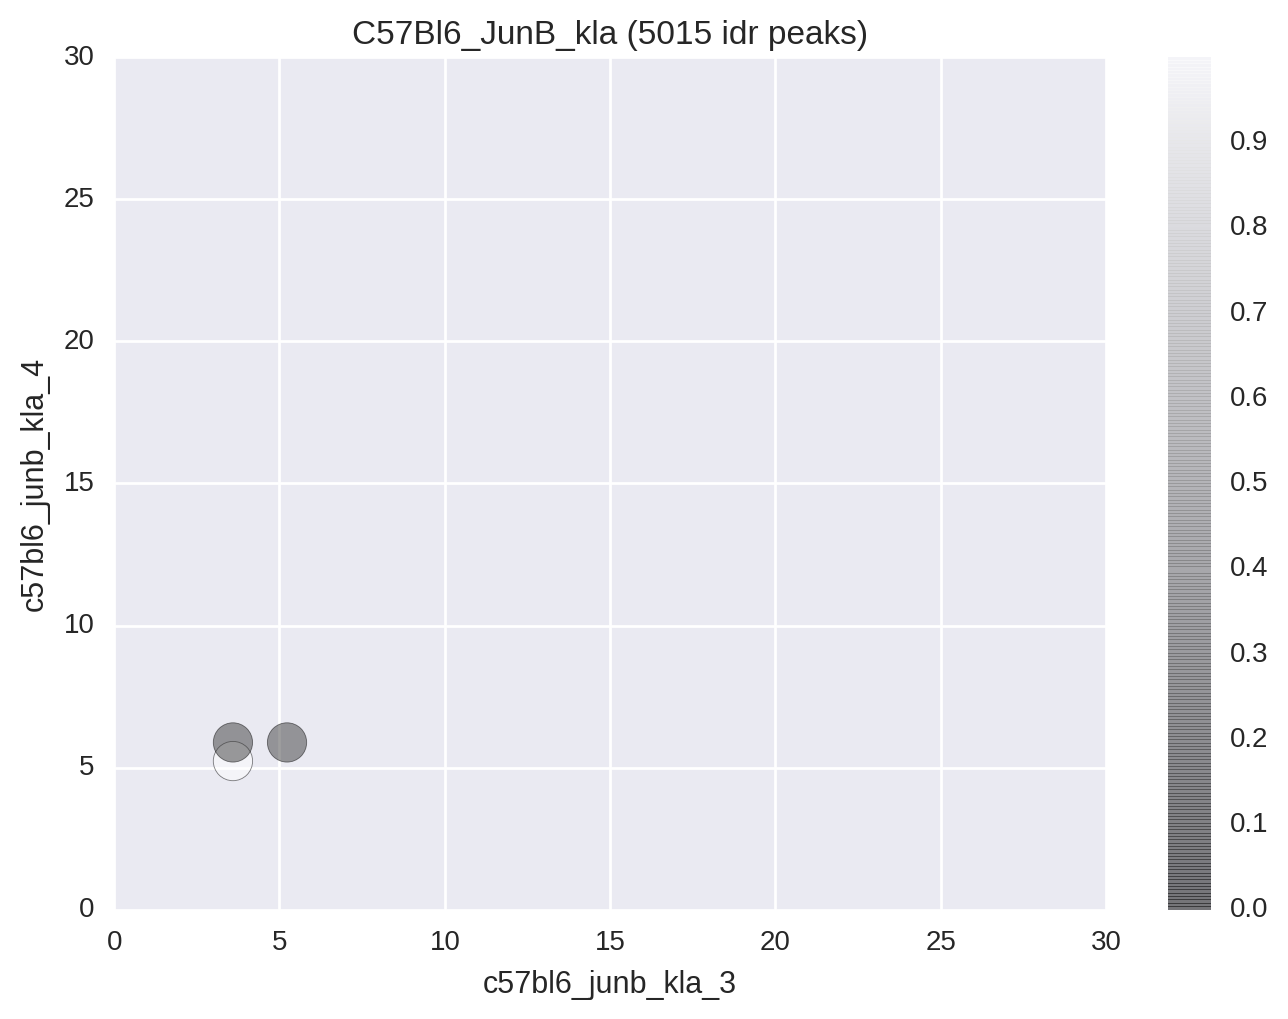

[ 0.          0.          0.99447514  0.          0.09392265  0.0718232 ]


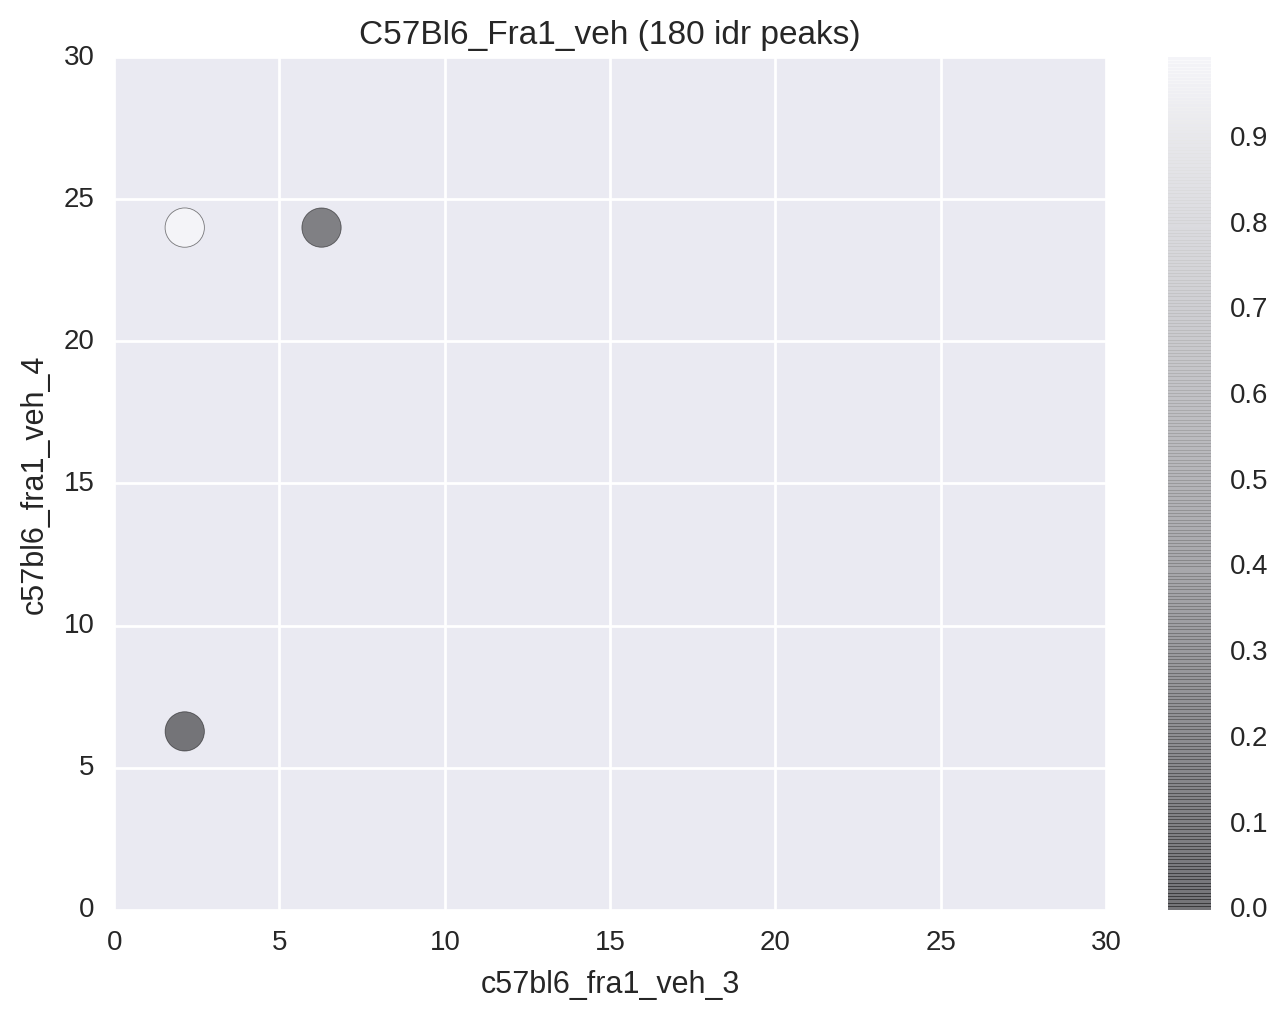

[ 0.99986969]


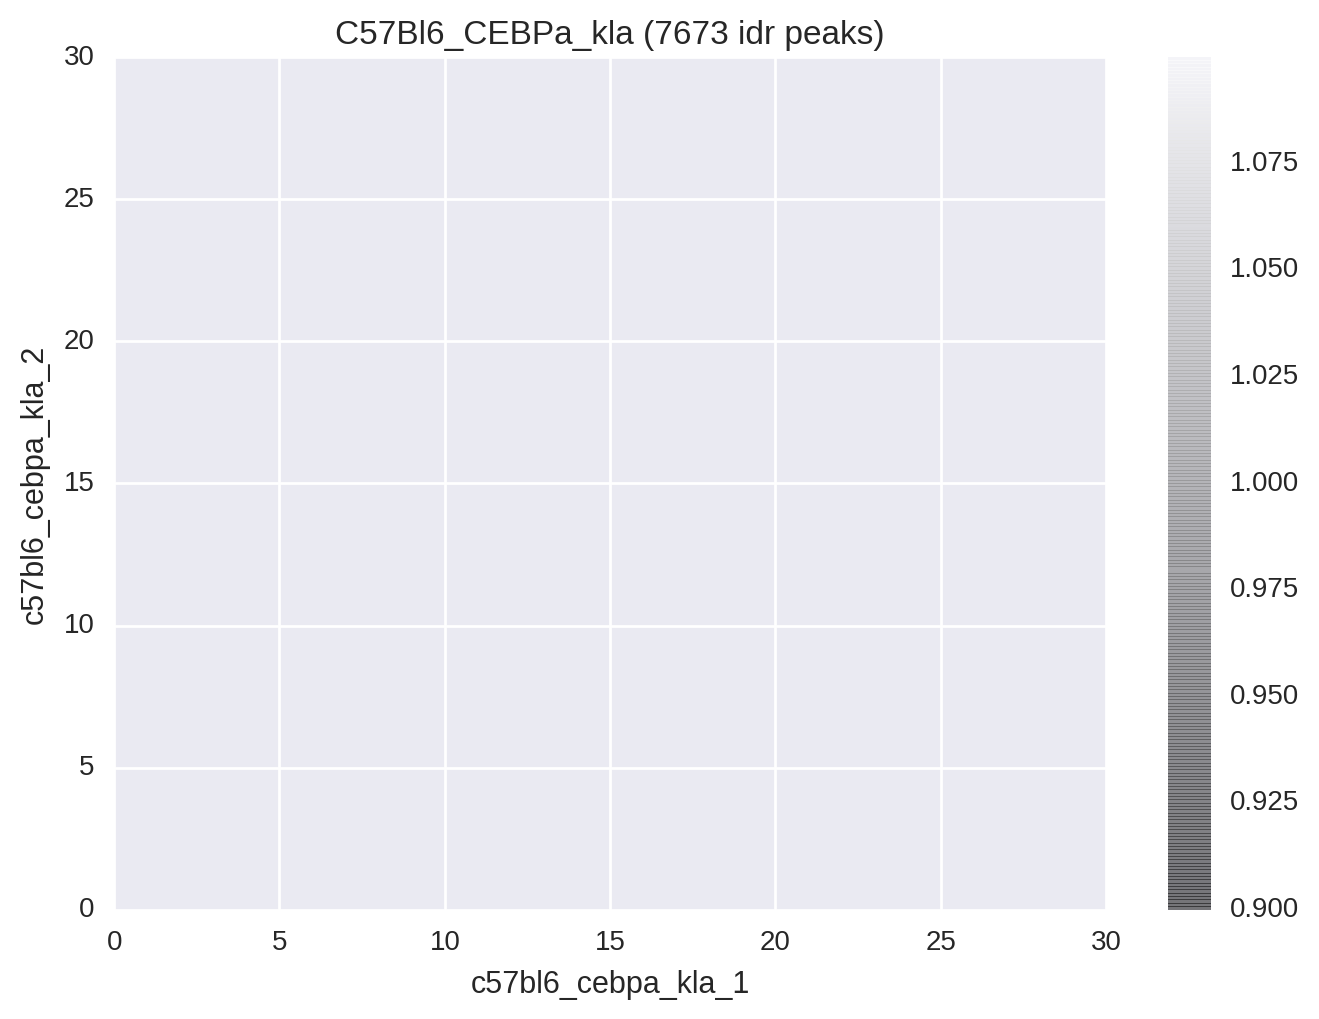

[ 0.91027057  0.99996056  0.95219689]


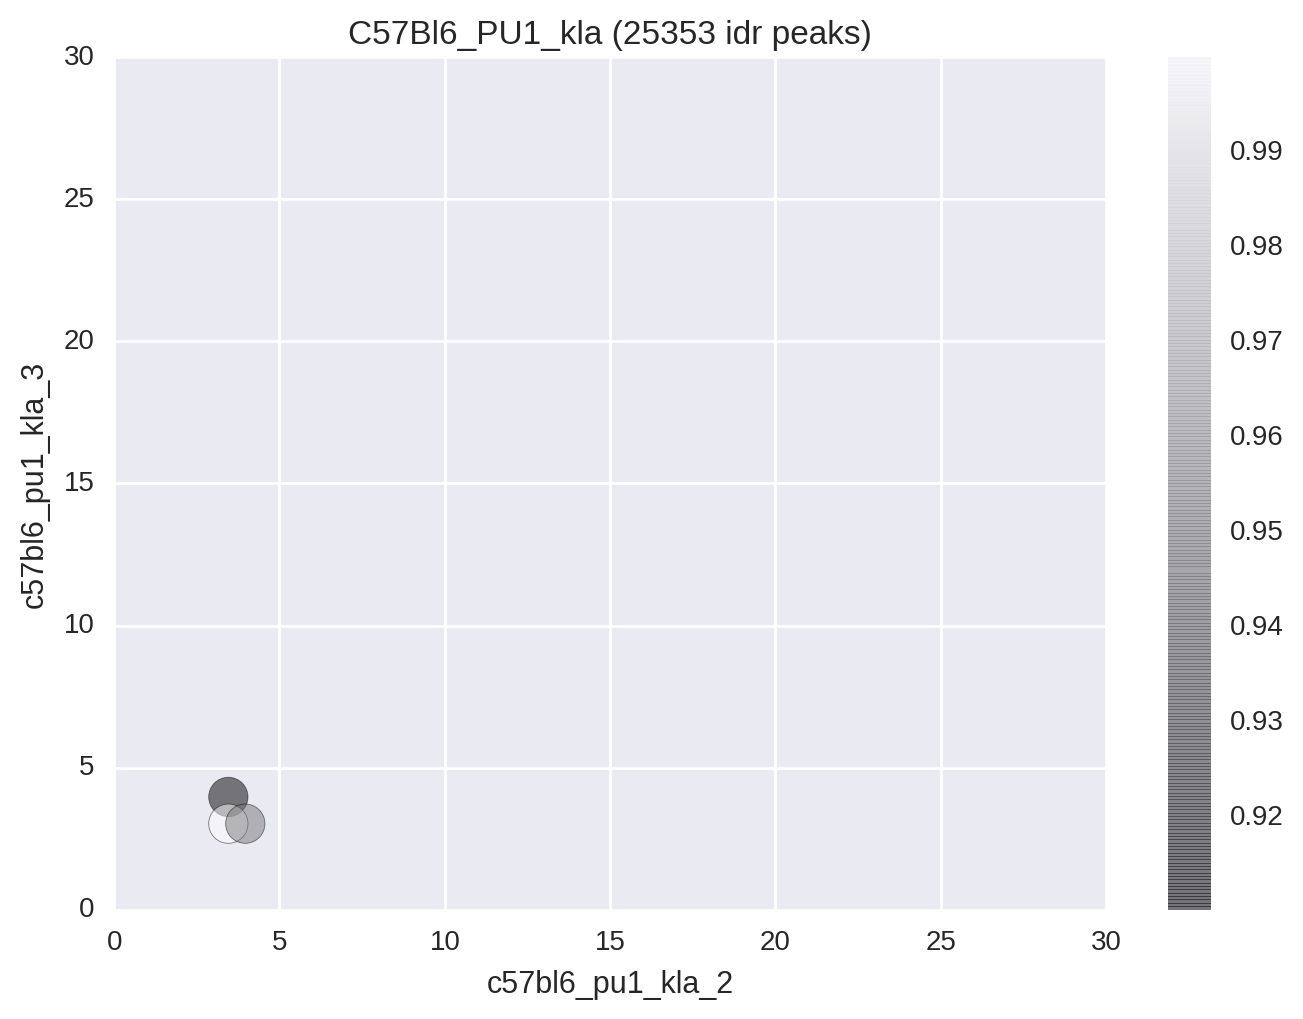

[ 0.0866366   0.99976264  0.47828151  0.03702825  0.08141467  0.00261097
  0.          0.20935201  0.          0.        ]


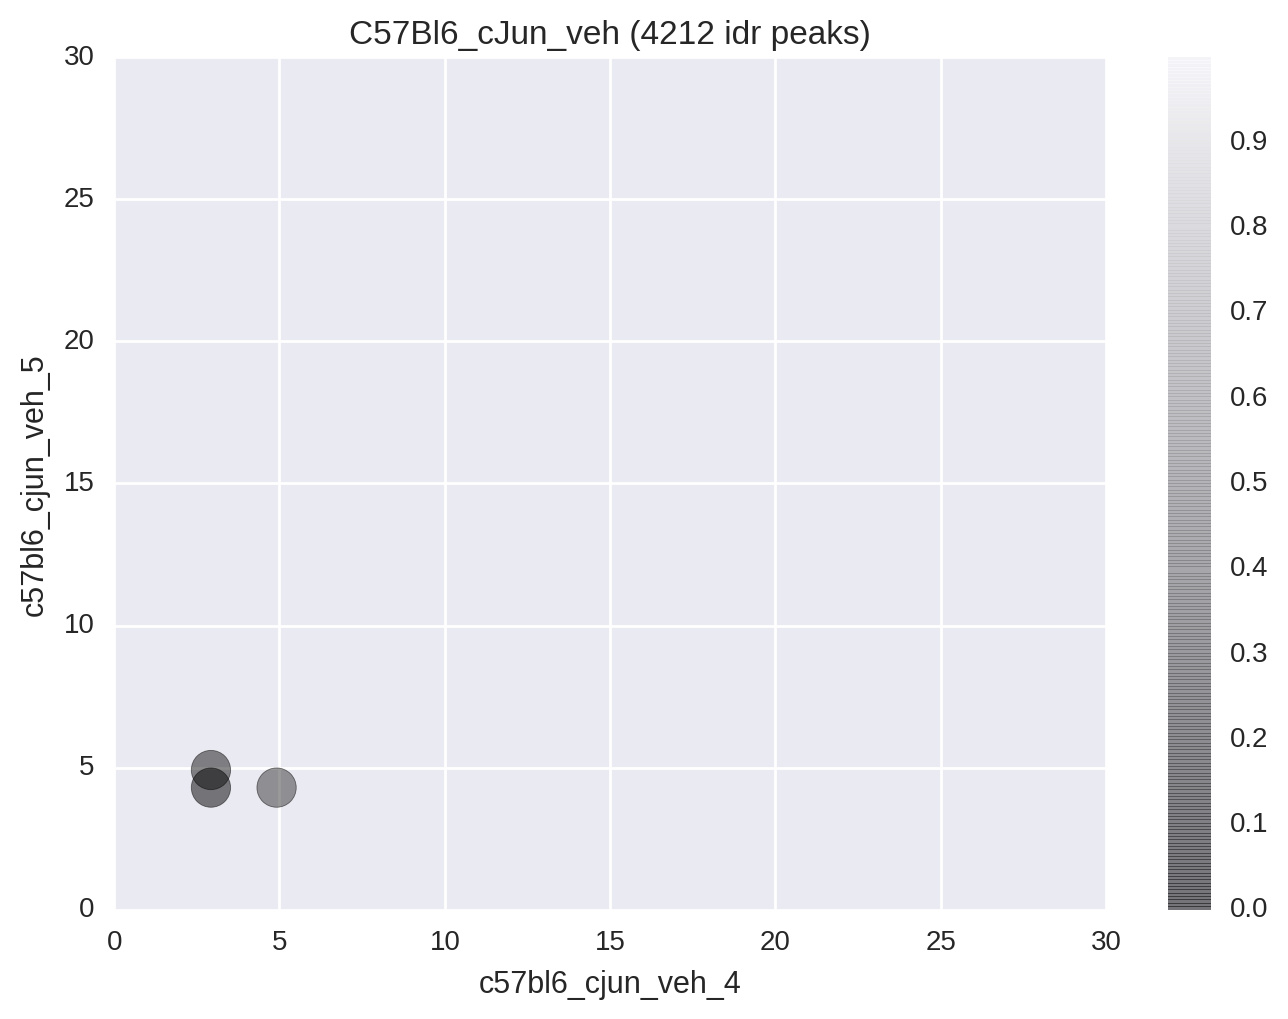

[ 0.]


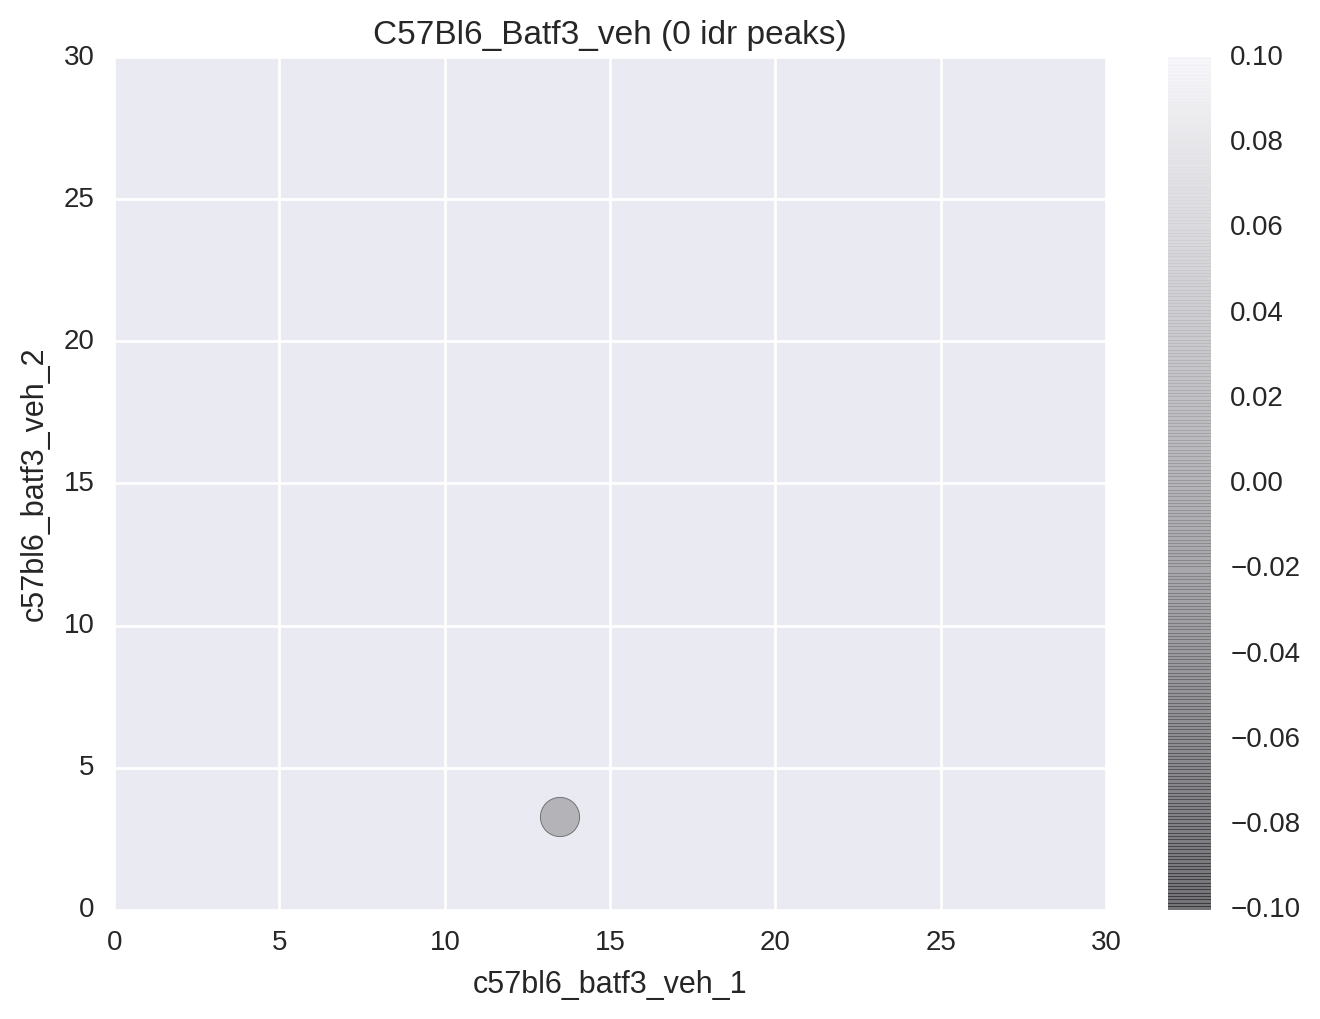

[ 0.36439842  0.66715976  0.9995069 ]


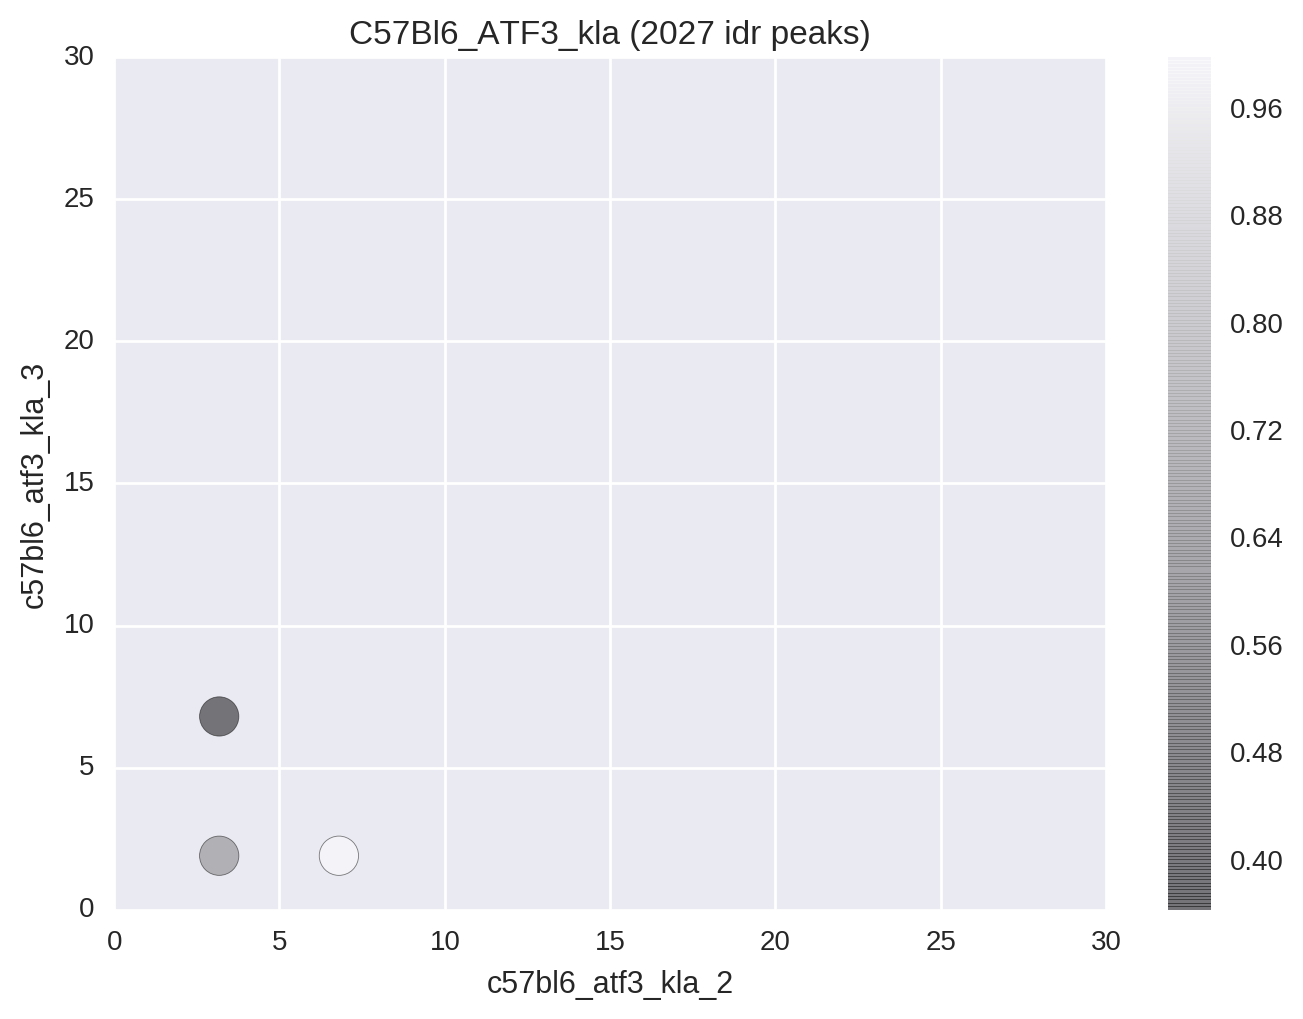

[ 0.90968053  0.99996294  0.91946483]


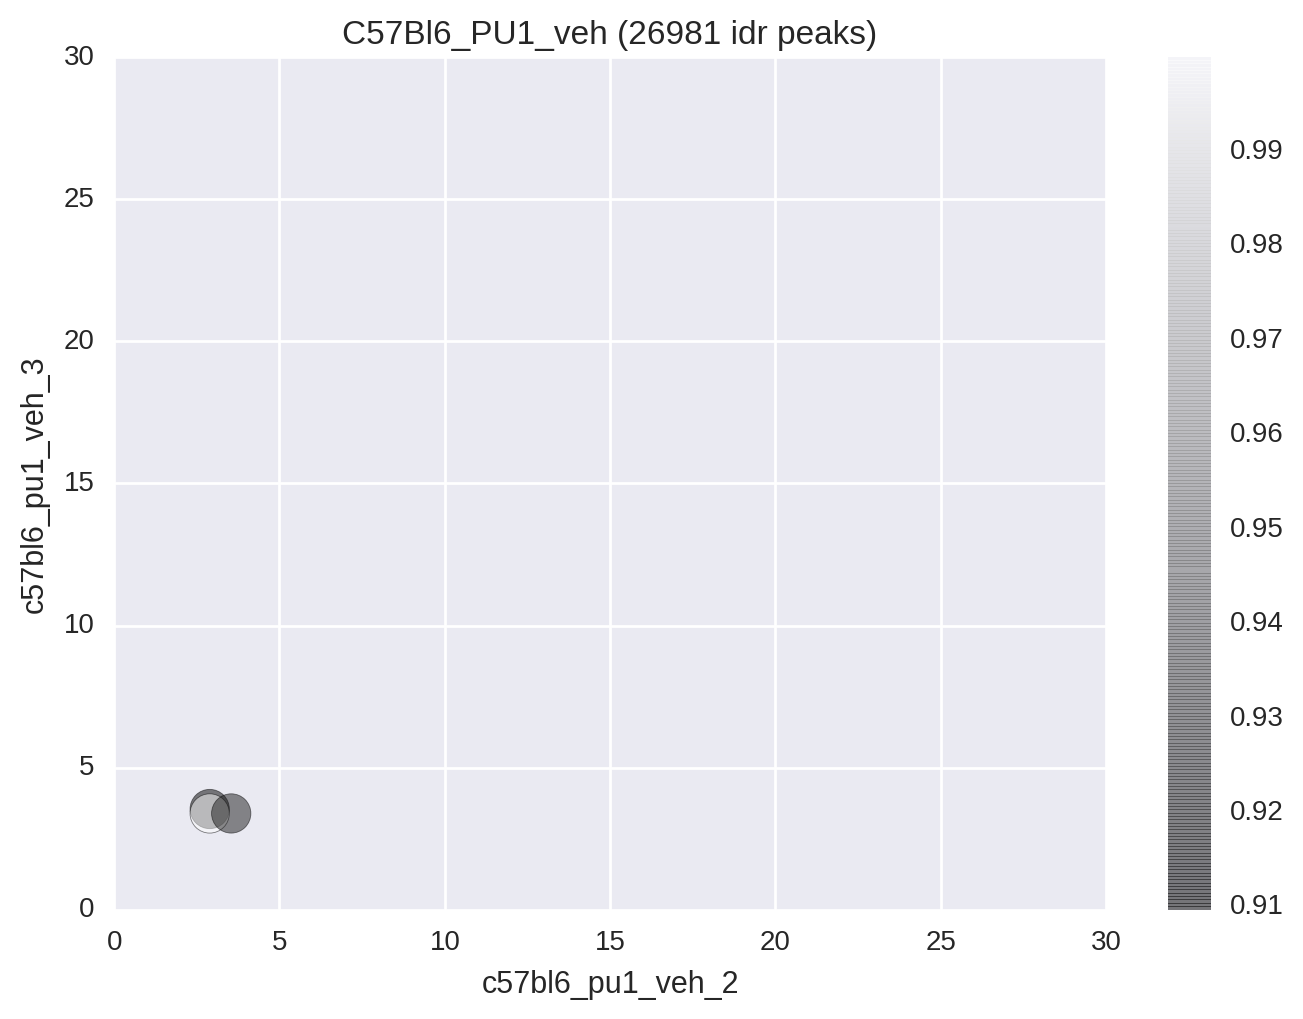

[ 0.99780702]


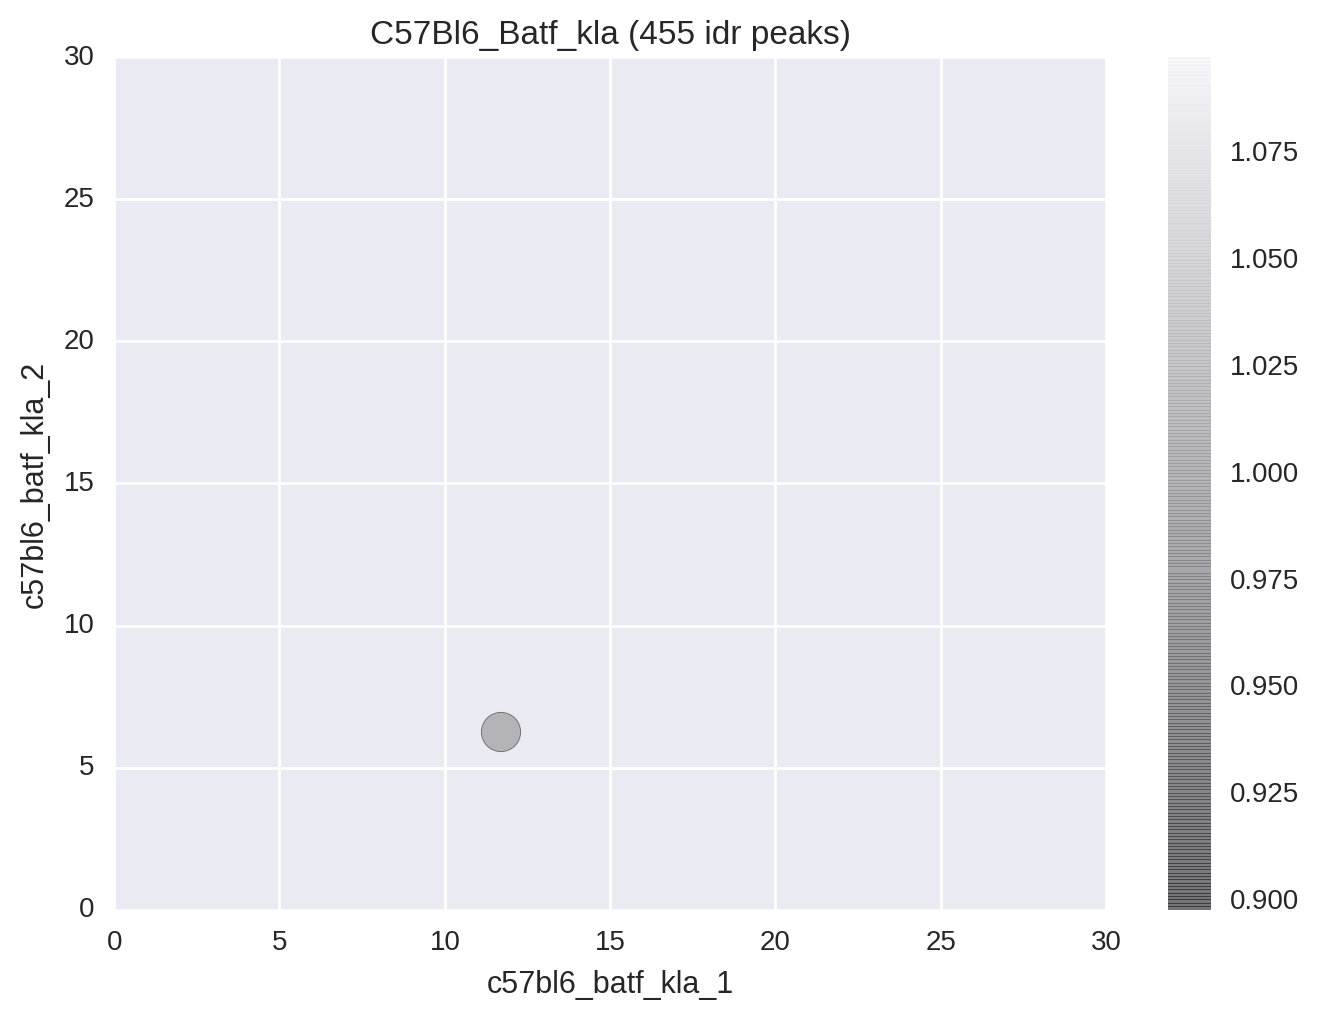

[ 0.96875  0.03125  0.     ]


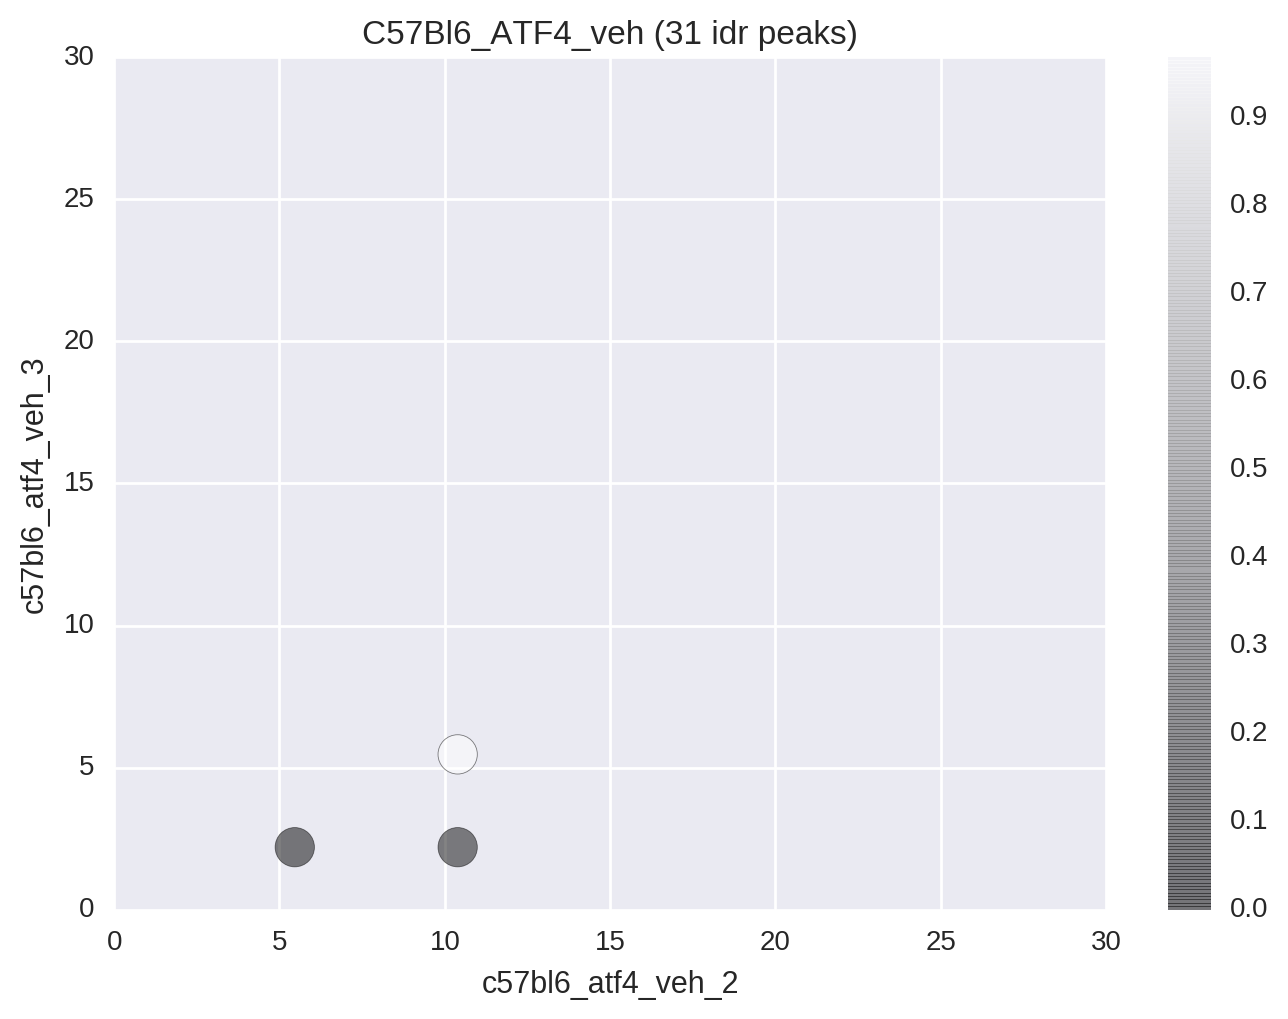

[ 0.          0.3125      0.          0.97916667  0.02083333  0.        ]


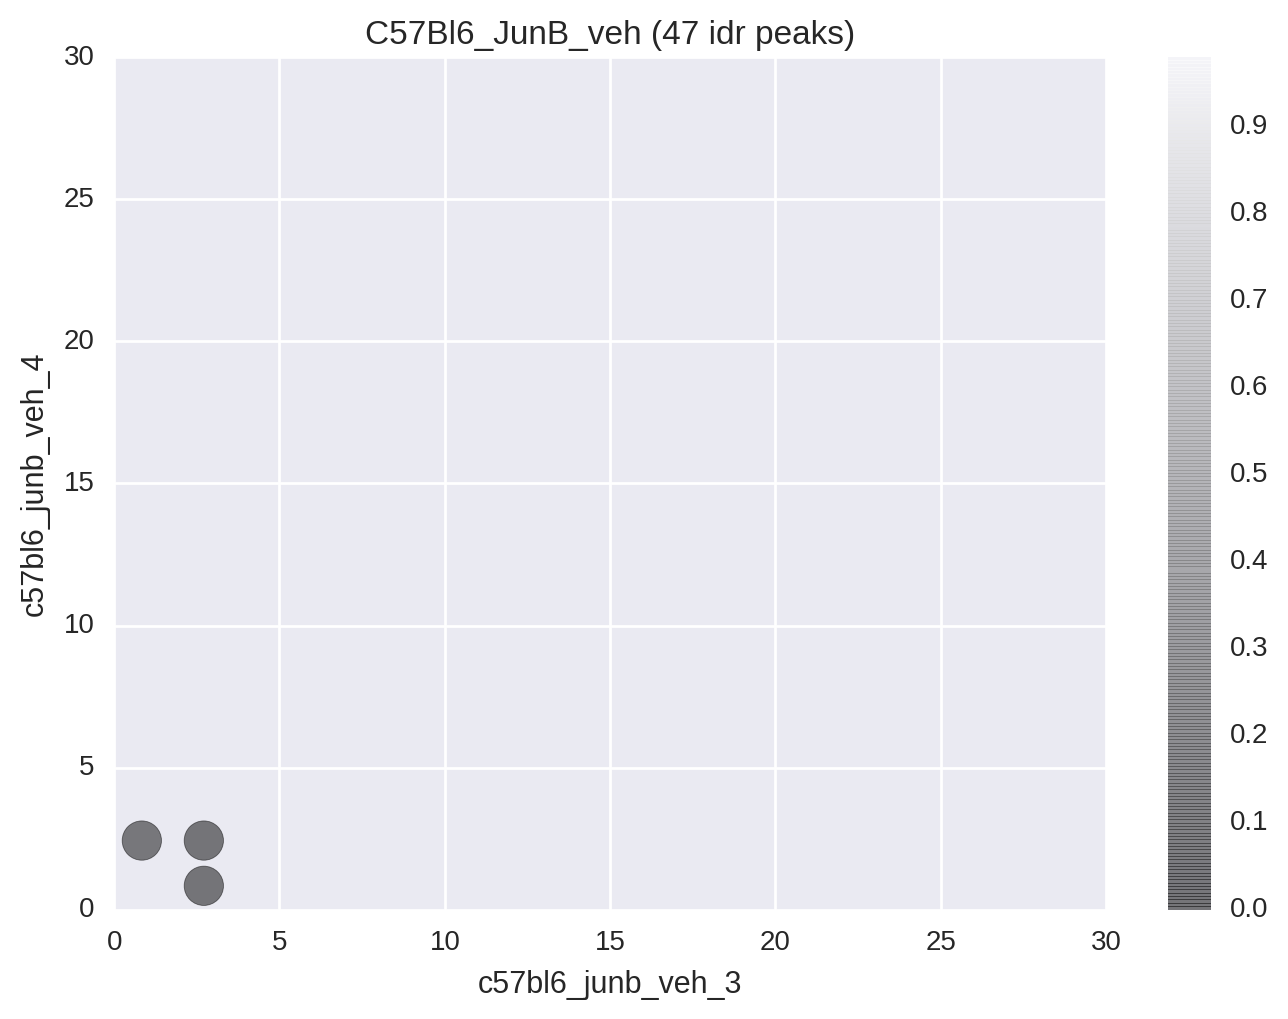

[ 0.02777778  0.          0.97222222  0.83333333  0.88888889  0.80555556]


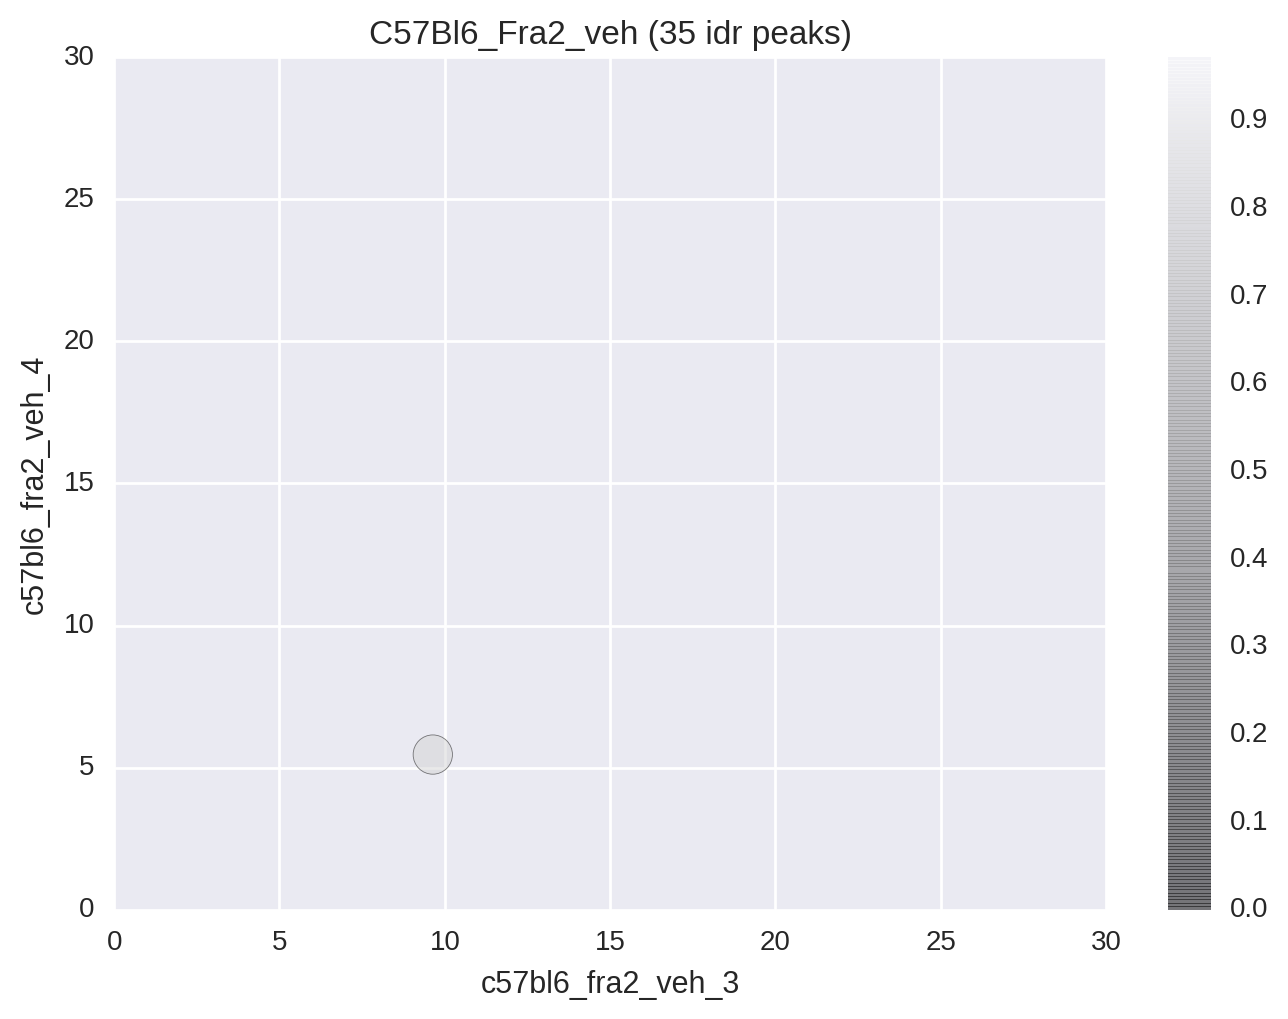

[  0.00000000e+00   2.47939007e-04   1.85954255e-04   1.92152730e-03
   7.43817021e-04   2.74716420e-01   6.77183413e-01   2.96968946e-01
   9.99938015e-01   2.22277320e-01   5.45465815e-02   3.12217195e-01
   1.03514535e-01   5.10568400e-01   1.75664786e-01]


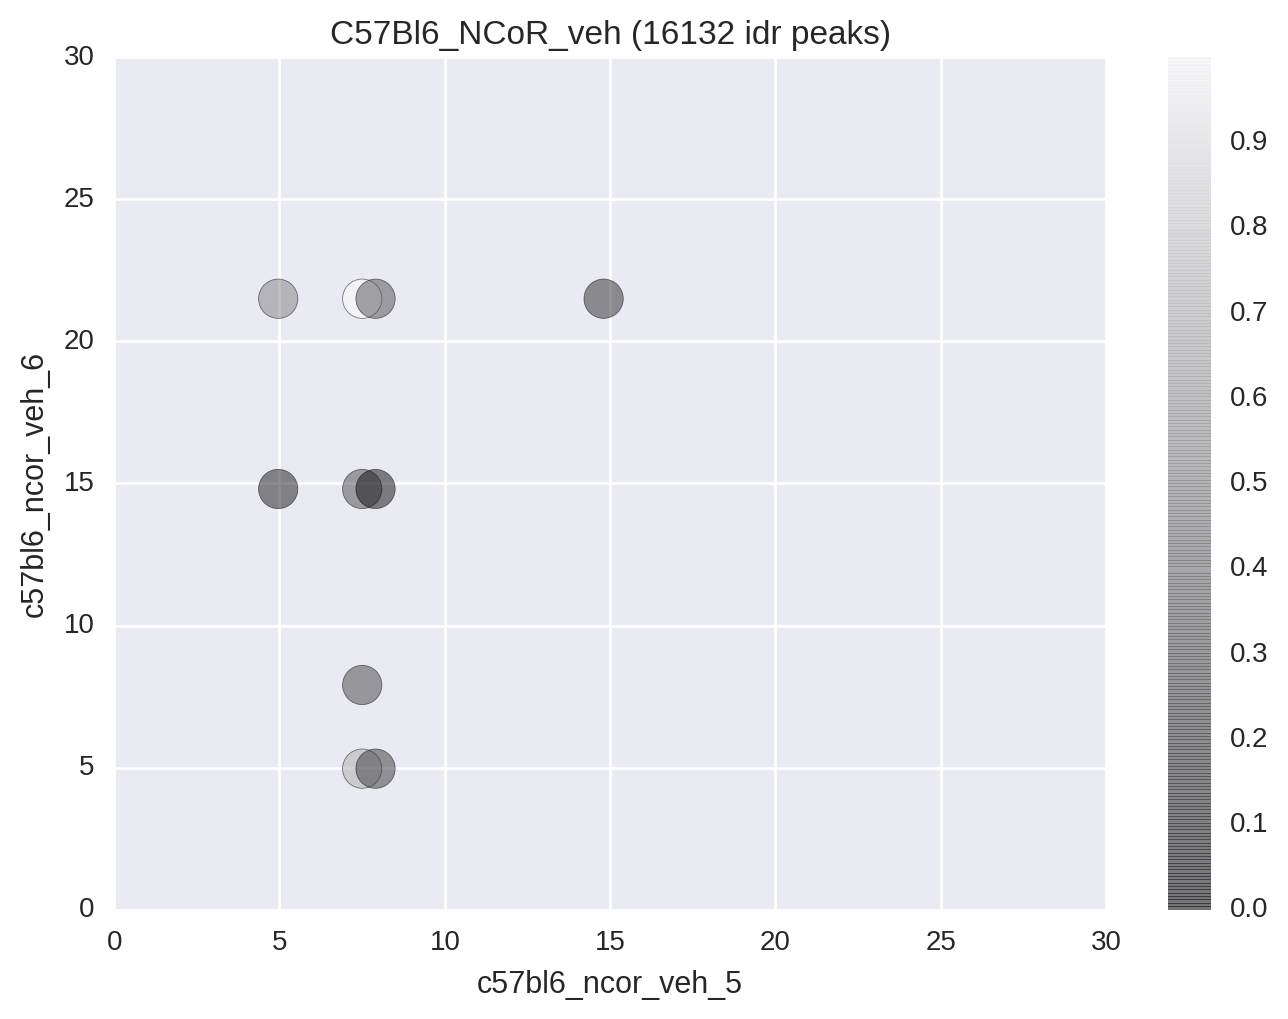

[ 0.]


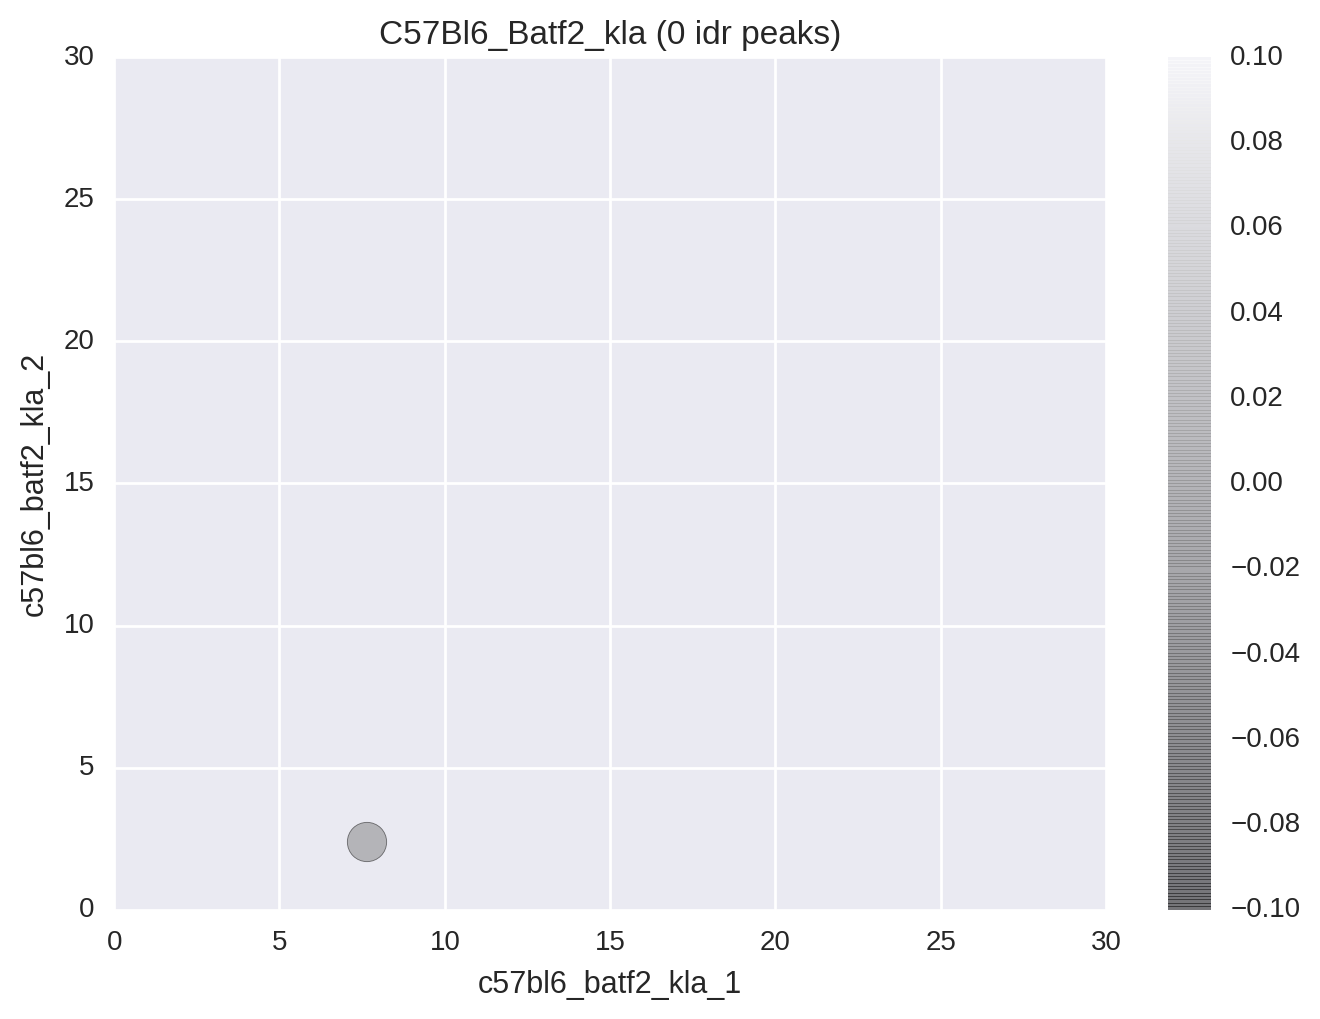

In [166]:
### plot sample skew versus number of IDR peaks for each pair of samples
current_frame = plotting_frame
sns.set_context('notebook')
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)
for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    skews_1 = []
    skews_2 = []
    idr_peaks = []
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]

            skew1 = sample_skew_dict[sample1]
            skew2 = sample_skew_dict[sample2]
            
            skews_1.append(skew1)
            skews_2.append(skew2)
            idr_peaks.append(samplePair_idrPeaks_dict[(sample1,sample2)])

    idr_peaks= np.array(idr_peaks)
    plt.scatter(skews_1, skews_2, c=idr_peaks/(np.max(idr_peaks) + 1), s=200, alpha=0.5)
    print(idr_peaks/(np.max(idr_peaks) + 1))
    plt.colorbar()
    plt.xlabel(sample1)
    plt.ylabel(sample2)
    plt.xlim([0,30])
    plt.ylim([0,30])
    plt.title('_'.join(list(ri)) + ' (' + str(np.max(idr_peaks)) + ' idr peaks)')
    plt.gray()
    plt.savefig('_'.join(list(ri))+'_skew.png')
    
    plt.show()

In [167]:
### plot sample skew versus number of IDR peaks for all samples
current_frame = plotting_frame
sns.set_context('notebook')
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    
skews_1 = []
skews_2 = []
idr_fractions = []
idr_peaks = []
for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    current_idr_peaks = []
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]

            skew1 = sample_skew_dict[sample1]
            skew2 = sample_skew_dict[sample2]
            
            skews_1.append(skew1)
            skews_2.append(skew2)
            idr_peaks.append(samples_idrPeaks_dict[(sample1,sample2)])

            current_idr_peaks.append(samples_idrPeaks_dict[(sample1,sample2)])
    current_idr_peaks = list(np.array(current_idr_peaks)/(np.max(current_idr_peaks)+1)) # note pseudo count in division
    idr_fractions = idr_fractions + current_idr_peaks 

idr_fractions= np.array(idr_fractions)
plt.scatter(skews_1, skews_2, c=idr_fractions, s=np.array(idr_peaks), alpha=0.3)
plt.ylim([0,20])
plt.xlim([0,20])
plt.colorbar()


    


NameError: name 'samples_idrPeaks_dict' is not defined

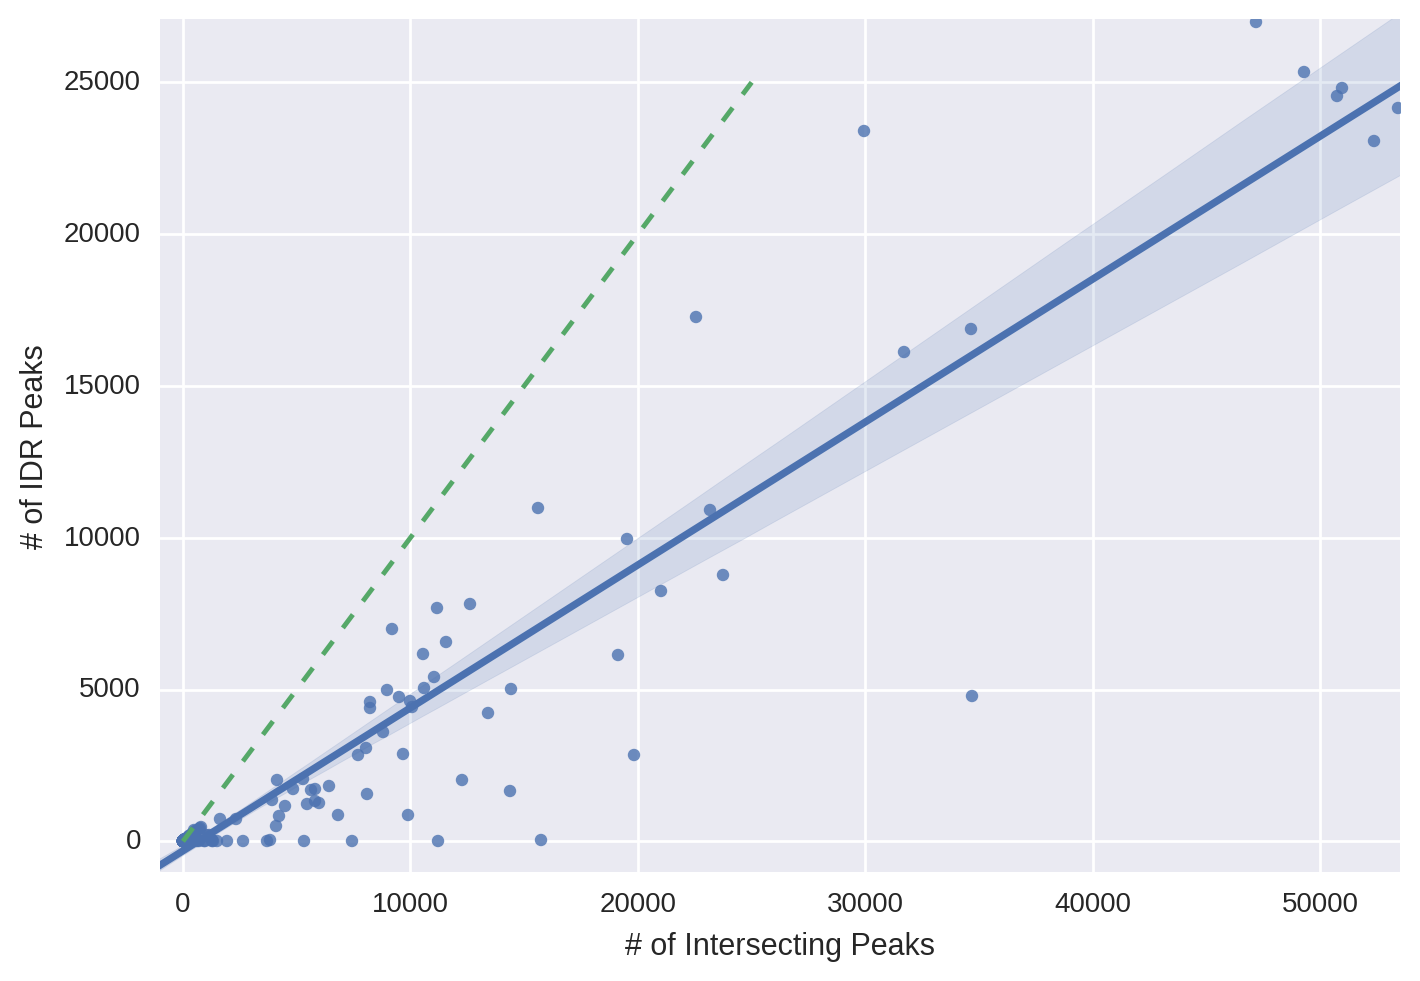

In [168]:
### plot the number of intersecting peaks versus the number of IDR peaks
intersecting_peaks = []
idr_peaks = []

for samplePair in samplePair_idrPeaks_dict:
    intersecting_peaks.append(samplePair_intersectingPeaks_dict[samplePair])
    idr_peaks.append(samplePair_idrPeaks_dict[samplePair])
sns.regplot(x=np.array(intersecting_peaks), y=np.array(idr_peaks))
plt.plot([0,25000],[0,25000], linestyle='--')
plt.xlabel('# of Intersecting Peaks')
plt.ylabel('# of IDR Peaks')
plt.ylim([-1000,np.max(idr_peaks)+100]);
plt.xlim([-1000,np.max(intersecting_peaks)+100]);

## Principal Component Analysis 

In [169]:
qc_metrics_frame = filtered_summary_frame[['totalReads', 
                       'uniquelyMappedReads', 
                       'fragmentLengthEstimate', 
                       'peakSizeEstimate', 
                       'tagsPerBP', 
                       'averageTagsPerPosition', 
                       'averageTagLength', 
                       'averageFragmentGCcontent', 
                       'uniquelyMappedFraction', 
                       'mappedFraction'
                      ]]
qc_metrics_frame.index = filtered_summary_frame['simplifiedName'].values
qc_metrics_frame['normalizedTagCountSkew'] = [sample_skew_dict[x] for x in qc_metrics_frame.index.values]
qc_metrics_frame['intersectingPeaks'] = [np.sum(plotting_frame[plotting_frame['sample'] == x]['intersects'].values) 
                                         for x in qc_metrics_frame.index.values]
qc_metrics_frame['idrPeaks'] = [np.sum(plotting_frame[plotting_frame['sample'] == x]['passed_idr'].values) 
                                         for x in qc_metrics_frame.index.values]
qc_metrics_frame['intersecting_fraction'] = [qc_metrics_frame.ix[x,'intersectingPeaks']/plotting_frame[plotting_frame['sample']==x].shape[0]
                                            for x in qc_metrics_frame.index.values]
qc_metrics_frame['idr_fraction'] = [qc_metrics_frame.ix[x,'idrPeaks']/plotting_frame[plotting_frame['sample']==x].shape[0]
                                            for x in qc_metrics_frame.index.values]
qc_metrics_frame['peaks'] = [plotting_frame[plotting_frame['sample']==x].shape[0]
                                            for x in qc_metrics_frame.index.values]
features = qc_metrics_frame.ix[:,:-5]
labels = qc_metrics_frame.ix[:,-5:]
normalized_features = pd.DataFrame(sklearn.preprocessing.normalize(features,axis=0))
normalized_features.columns = features.columns
normalized_features.index = features.index


In [170]:
normalized_features = pd.DataFrame(sklearn.preprocessing.normalize(features,axis=1))
normalized_features.columns = features.columns
normalized_features.index = features.index

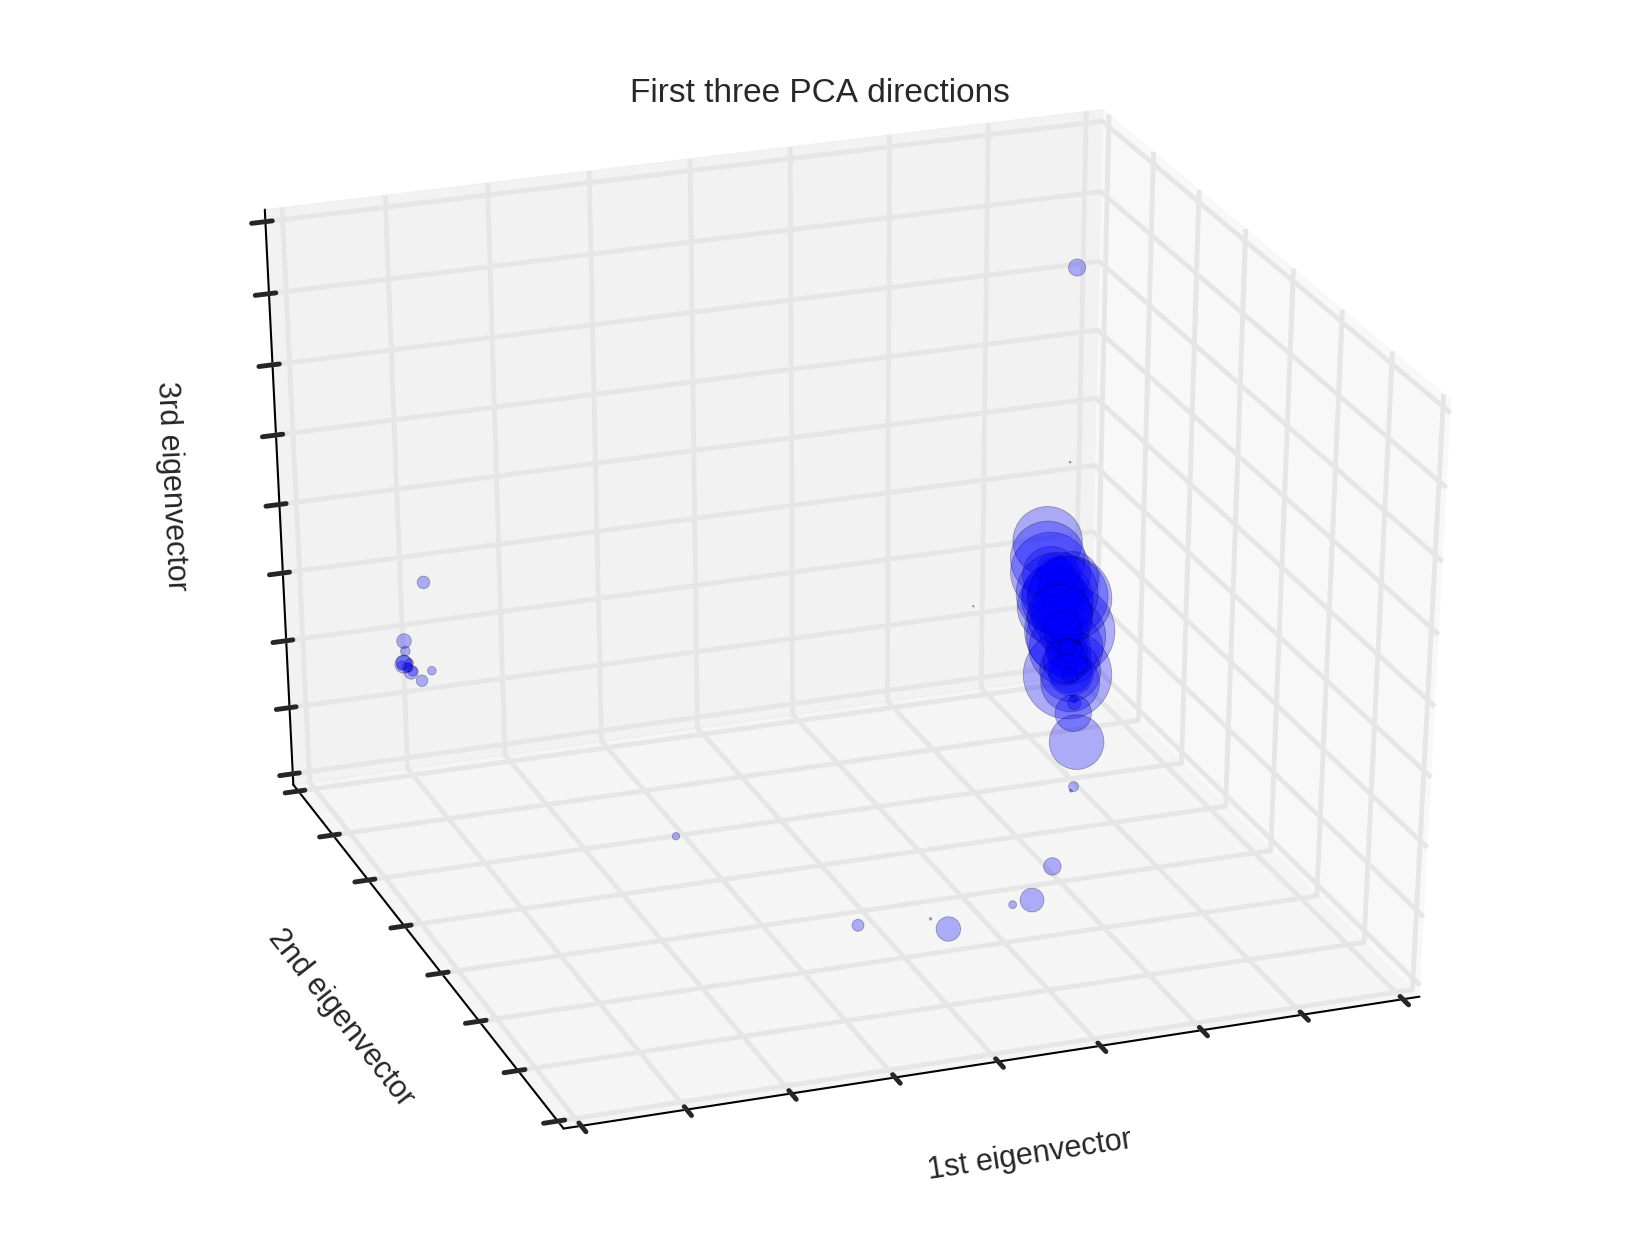

In [171]:

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
reduced_features = sklearn.decomposition.PCA(n_components=3).fit_transform(normalized_features)
ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
           s=labels['idr_fraction']*2000, alpha=0.3)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')
plt.show()



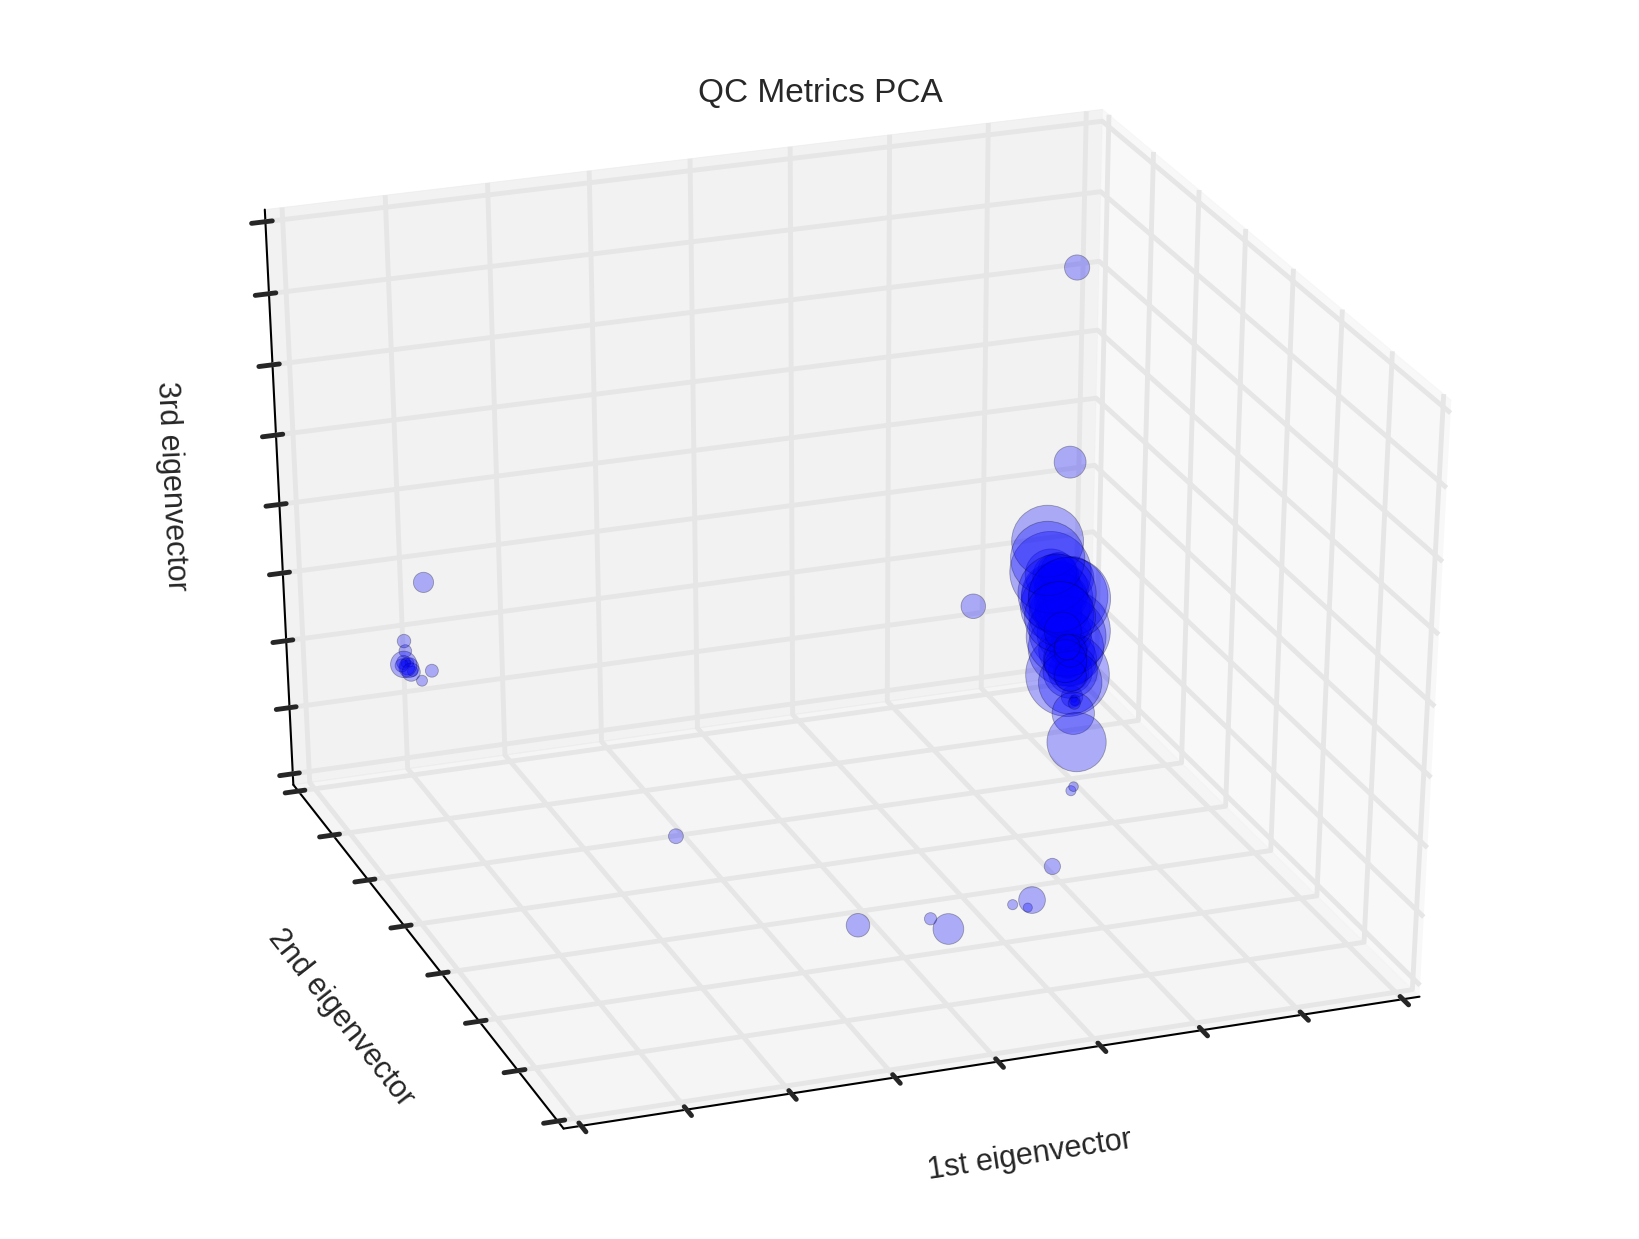

In [172]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
reduced_features = sklearn.decomposition.PCA(n_components=3).fit_transform(normalized_features)
ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
           s=labels['intersecting_fraction']*1000, alpha=0.3)
ax.set_title("QC Metrics PCA")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')
plt.show()


